# ***NOTEBOOK FOR ANALYSING THE `SYNTHEA` DATA***
***
- ***GOAL IS TO FIND STRONG REASONS BEHIND PATIENTS READMISSION***

## **Starting of Analysis**

### **Data Import, Creating Connection and Checking the data**

In [1]:
import os
from pathlib import Path

def get_project_root(project_name="ranojoy_data_analytics_projects"):
    """
    Universally finds the project root.
    1. Checks if we are inside the project (standard usage).
    2. Checks if we are above the project (your specific usage).
    """
    current_path = Path.cwd()

    # CASE 1: Standard Usage (Running from inside the repo)
    if project_name in str(current_path):
        while current_path.name != project_name:
            current_path = current_path.parent
        return current_path

    # CASE 2: Your Setup (Running from 'Machine' or a parent folder)
    # We search specifically for the project folder inside the current directory
    # limiting depth to 4 levels to keep it fast.
    else:
        # rglob searches recursively for the folder name
        for path in current_path.rglob(project_name):
            if path.is_dir():
                return path
        
        raise FileNotFoundError(f"Could not find project: {project_name}")

# --- USAGE ---
repo_root = get_project_root()

# Build path to your data folder
# This will work on your PC AND on anyone else's PC
data_path = repo_root / "About Synthea - Why Patients Readmit More"
print(data_path)

C:\Users\Rano's PC\Machine\github_repo_cloned\ranojoy_data_analytics_projects\About Synthea - Why Patients Readmit More


In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append(os.path.abspath(f"{data_path}"))

import src.plots as P
import src.stat_tests as S

In [3]:
# The Correct Way (Universal)
file_path = data_path / "data" / "processed_data" / "processed_synthea_data.csv"

data = pd.read_csv(file_path)

In [4]:
pd.set_option('display.max_columns',None)

In [5]:
data.head()

encounter_start     encounter_finish encounterclass  \
0  2010-11-09 15:06:37  2010-11-09 15:36:37       WELLNESS   
1  2011-11-15 15:06:37  2011-11-15 15:21:37       WELLNESS   
2  2012-08-03 15:06:37  2012-08-03 15:36:37     AMBULATORY   
3  2012-10-14 15:06:37  2012-10-14 15:21:37     AMBULATORY   
4  2012-11-20 15:06:37  2012-11-20 15:36:37       WELLNESS   

   base_encounter_cost  payer_coverage  encounter_duration  total_procedures  \
0               129.16          129.16                30.0                 1   
1               129.16          129.16                15.0                 0   
2               129.16           54.16                30.0                 1   
3               129.16           54.16                15.0                 0   
4               129.16          129.16                30.0                 1   

   avg_procedure_cost     medication_start       medication_end  \
0              648.01                  NaN                  NaN   
1                0.00                  NaN                  NaN   
2             2230.40                  NaN                  NaN   
3                0.00  2012-10-14 15:06:37  2012-10-25 15:06:37   
4              590.58                  NaN                  NaN   

   total_medicines  avg_base_medicine_cost  avg_total_medicine_cost  \
0                0                    0.00                     0.00   
1                0                    0.00                     0.00   
2                0                    0.00                     0.00   
3                1                   20.48                    20.48   
4                0                    0.00                     0.00   

   reasons_for_medications condition_start condition_end  \
0                        0             NaN           NaN   
1                        0             NaN           NaN   
2                        0      2012-08-03    2012-08-11   
3                        1      2012-10-14    2012-10-25   
4                        0             NaN           NaN   

   is_ongoing_condition  total_conditions careplan_start careplan_end  \
0                    -1                 0            NaN          NaN   
1                    -1                 0            NaN          NaN   
2                     0                 1            NaN          NaN   
3                     0                 1            NaN          NaN   
4                    -1                 0            NaN          NaN   

   is_ongoing_careplan  total_careplans  age_as_2022  marital   race  \
0                   -1                0           18  UNKNOWN  WHITE   
1                   -1                0           18  UNKNOWN  WHITE   
2                   -1                0           18  UNKNOWN  WHITE   
3                   -1                0           18  UNKNOWN  WHITE   
4                   -1                0           18  UNKNOWN  WHITE   

     ethnicity patient_gender provider_gender  utilization  \
0  NONHISPANIC              M               M           25   
1  NONHISPANIC              M               M           25   
2  NONHISPANIC              M               M         1616   
3  NONHISPANIC              M               M         1616   
4  NONHISPANIC              M               M           25   

   caused_readmission condition_duration careplan_duration  
0                   0                NaN               NaN  
1                   0                NaN               NaN  
2                   0             8 days               NaN  
3                   0            11 days               NaN  
4                   0                NaN               NaN

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53346 entries, 0 to 53345
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   encounter_start          53346 non-null  object 
 1   encounter_finish         53346 non-null  object 
 2   encounterclass           53346 non-null  object 
 3   base_encounter_cost      53346 non-null  float64
 4   payer_coverage           53346 non-null  float64
 5   encounter_duration       53346 non-null  float64
 6   total_procedures         53346 non-null  int64  
 7   avg_procedure_cost       53346 non-null  float64
 8   medication_start         27269 non-null  object 
 9   medication_end           26037 non-null  object 
 10  total_medicines          53346 non-null  int64  
 11  avg_base_medicine_cost   53346 non-null  float64
 12  avg_total_medicine_cost  53346 non-null  float64
 13  reasons_for_medications  53346 non-null  int64  
 14  condition_start       

In [7]:
data.shape

(53346, 32)

In [8]:
data.isnull().sum()[data.isnull().sum()>0].reset_index(name = 'null_counts')

index  null_counts
0    medication_start        26077
1      medication_end        27309
2     condition_start        45696
3       condition_end        48884
4      careplan_start        49874
5        careplan_end        51395
6  condition_duration        48884
7   careplan_duration        51395

In [9]:
data[['careplan_duration','condition_duration']] = data[['careplan_duration','condition_duration']].fillna(0)

In [10]:
data['condition_duration']= data['condition_duration'].str.replace(' days',"").astype('Int64')

In [11]:
data['careplan_duration']= data['careplan_duration'].str.replace(' days',"").astype('Int64')

In [153]:
data.describe().round(2).T

count     mean      std    min     25%     50%  \
base_encounter_cost      53346.0   128.75     4.58  77.49  129.16  129.16   
payer_coverage           53346.0     62.0    43.61    0.0   17.49   69.16   
total_procedures         53346.0     0.66      1.7    0.0     0.0     0.0   
avg_procedure_cost       53346.0  2129.45  5596.18    0.0     0.0     0.0   
total_medicines          53346.0      0.8      1.2    0.0     0.0     1.0   
avg_base_medicine_cost   53346.0   162.61   406.75    0.0     0.0     6.8   
avg_total_medicine_cost  53346.0  1431.68  9931.92    0.0     0.0    7.22   
reasons_for_medications  53346.0      0.5     0.61    0.0     0.0     0.0   
is_ongoing_condition     53346.0     -0.8     0.53   -1.0    -1.0    -1.0   
total_conditions         53346.0     0.16     0.41    0.0     0.0     0.0   
is_ongoing_careplan      53346.0    -0.91     0.38   -1.0    -1.0    -1.0   
total_careplans          53346.0     0.07     0.25    0.0     0.0     0.0   
age_as_2022              53346.0    55.66    25.87    0.0    35.0    58.0   
utilization              53346.0   1329.7  1427.73    1.0    86.0   821.0   
caused_readmission       53346.0     0.39     0.49    0.0     0.0     0.0   
condition_duration       53346.0     7.46   156.34    0.0     0.0     0.0   
careplan_duration        53346.0     7.07   117.48    0.0     0.0     0.0   

                             75%         max  
base_encounter_cost       129.16      129.16  
payer_coverage             89.16      129.16  
total_procedures             1.0        21.0  
avg_procedure_cost        602.04   187968.69  
total_medicines              1.0        10.0  
avg_base_medicine_cost    263.49     6901.17  
avg_total_medicine_cost  1783.74  1296594.95  
reasons_for_medications      1.0         4.0  
is_ongoing_condition        -1.0         1.0  
total_conditions             0.0         7.0  
is_ongoing_careplan         -1.0         1.0  
total_careplans              0.0         2.0  
age_as_2022                 73.0       112.0  
utilization               2159.0      4828.0  
caused_readmission           1.0         1.0  
condition_duration           0.0     17946.0  
careplan_duration            0.0     10203.0

### ***Outlier Interpretation from numerical columns***

- **max value of `avg_procedure_cost` is very high**

- **max value of `average_total_medicine_cost` is too high**

- **`utilization` column is spreaded from 1 to 4828**

- **`age` column have values from 0 to 112 as of 2022**

- **max value in `condition_duration` is too high**

- **max value for `careplan_duration` is also very high**

In [21]:
data.describe(include='object').T

count unique                  top   freq
encounter_start  53346  50029  1973-07-27 23:35:03      7
encounterclass   53346      6             WELLNESS  19106
duration         53346      4             same_day  51759
marital          53346      3              MARRIED  30413
race             53346      5                WHITE  41794
ethnicity        53346      2          NONHISPANIC  49267
patient_gender   53346      2                    F  26891
provider_gender  53346      2                    F  31135

### ***Statistical insights from categorical columns***

- **max `encounter` in single day is 7**

- **`encounter_class` have 6 uniqe values, wellness being most frequent**

- **`duration` column have 4 unique values, same_day being the most frequent**

## **Univariate Analysis**

**encounter_class**

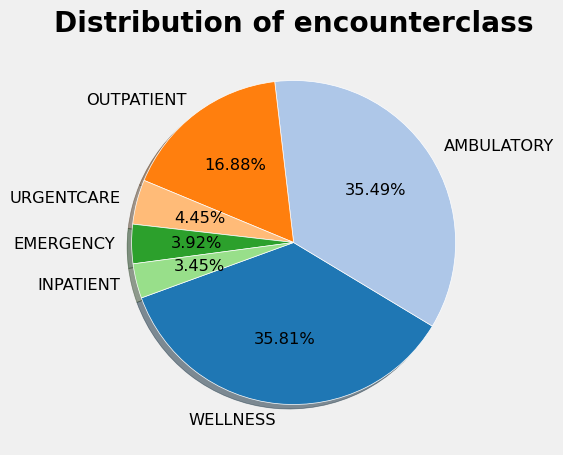

In [22]:
plt.figure(figsize=(5,5))
P.plot_pie(column='encounterclass',data = data)
plt.show()

- **nearly 70% of observations are from wellness and ambulatory class**

**base_encounter_cost**

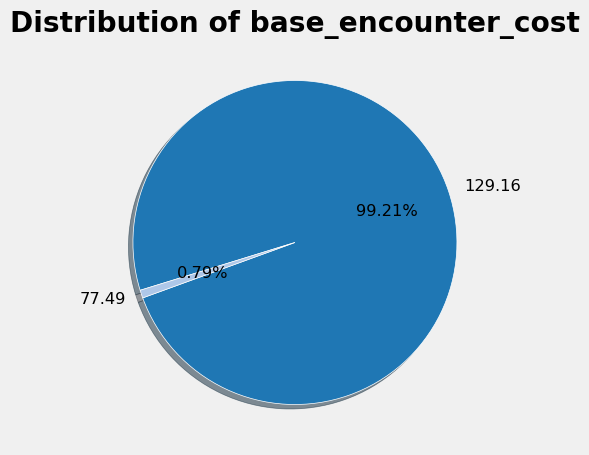

In [23]:
plt.figure(figsize=(5,5))
P.plot_pie(column='base_encounter_cost',data = data)
plt.show()

In [24]:
data['base_encounter_cost']=data['base_encounter_cost'].astype('object')

***
- **only `2 types` of cost is associated with `encounters`, and more than `99%` of them being `129.16`**
***

**payer_coverage**

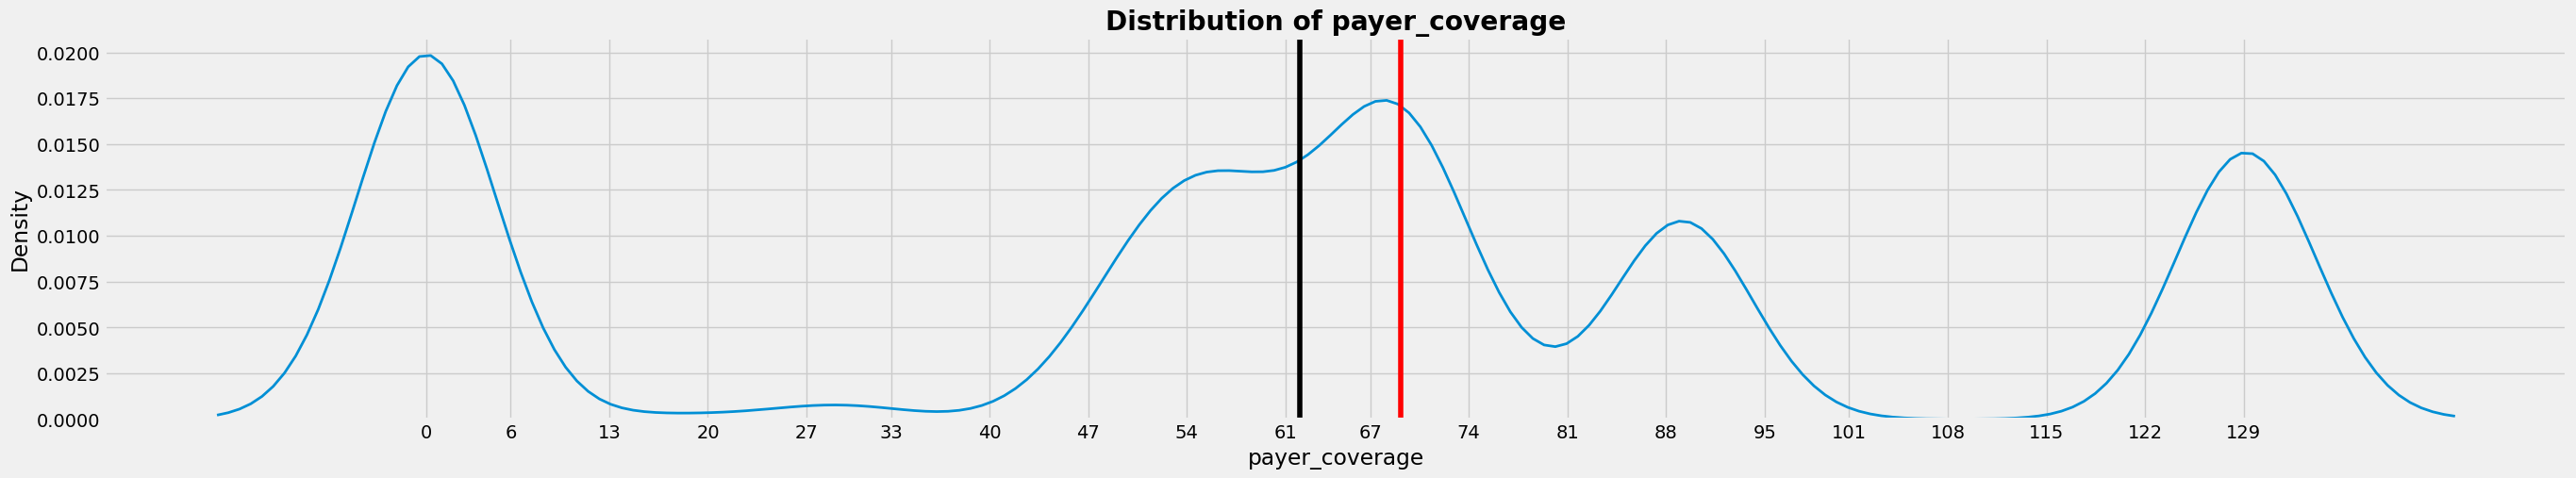

In [25]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'payer_coverage',data= data,line_val=.50)
plt.axvline(data['payer_coverage'].mean(),color = 'black')
plt.show()

- **there is peak in both the end as well as in the middle**

**duration**

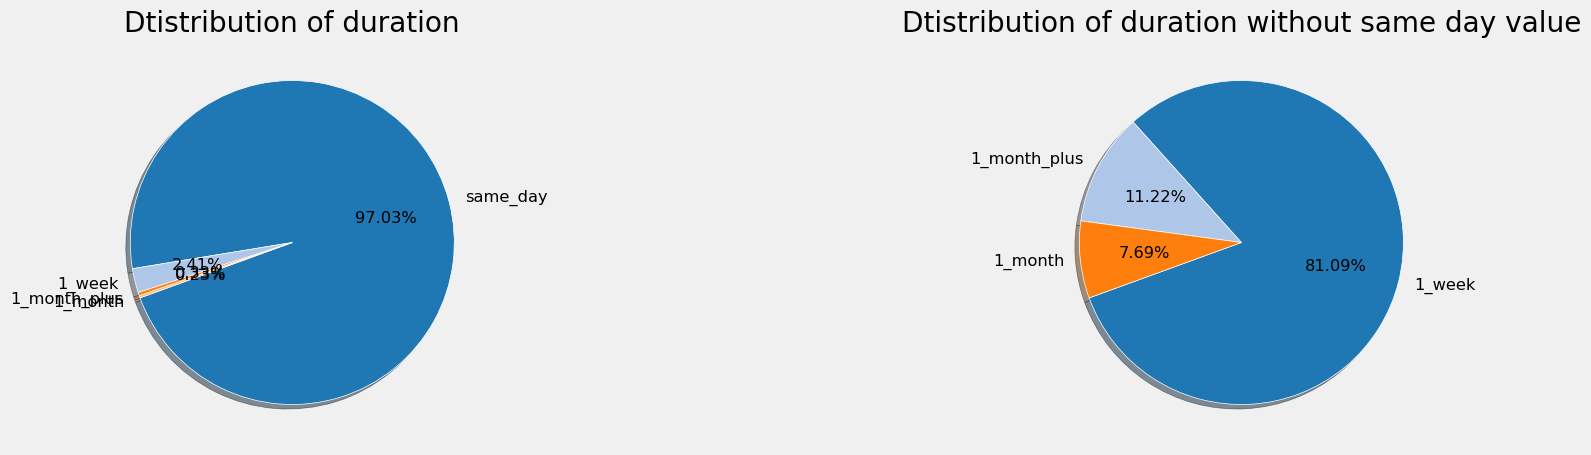

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
P.plot_pie(column='duration',data = data)
plt.title('Dtistribution of duration')
plt.subplot(1,2,2)
P.plot_pie(column='duration',data = data[data['duration'] != 'same_day'])
plt.title('Dtistribution of duration without same day value')
plt.show()

***
- **more than `97%` of encounter have `same day duration`, and among other duration category `1 week` is most frequent**
***

**total_procedures**

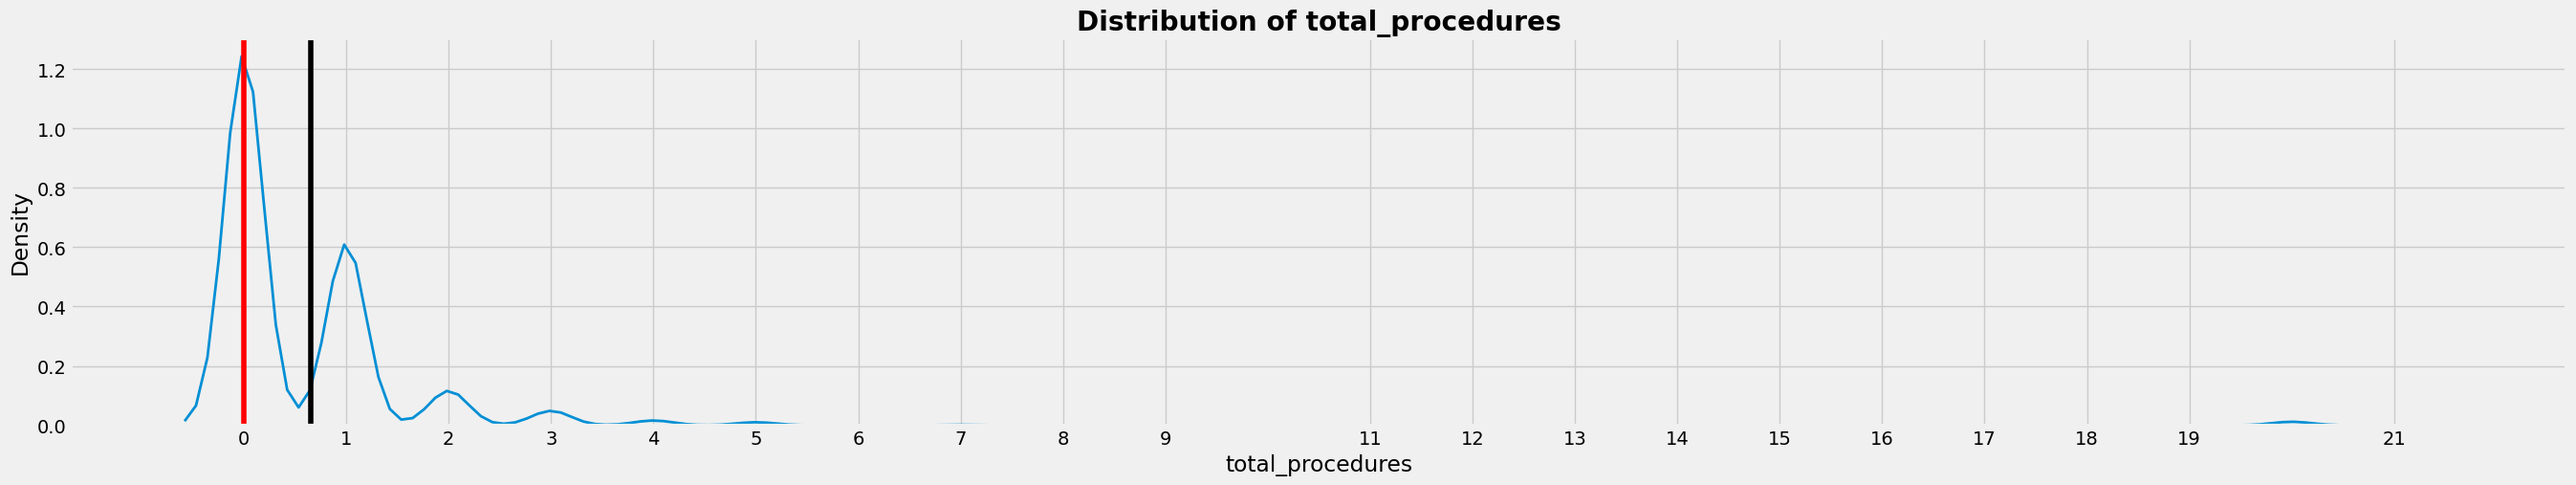

In [27]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'total_procedures',data= data,line_val=.50)
plt.axvline(data['total_procedures'].mean(),color = 'black')
plt.show()

In [28]:
data.groupby('total_procedures').size()

total_procedures
0     32274
1     15787
2      3000
3      1255
4       415
5       264
6         2
7        42
20      306
21        1
dtype: int64

In [29]:
data['total_procedures']=data['total_procedures'].apply(lambda x: '5+' if x>5 else str(x))

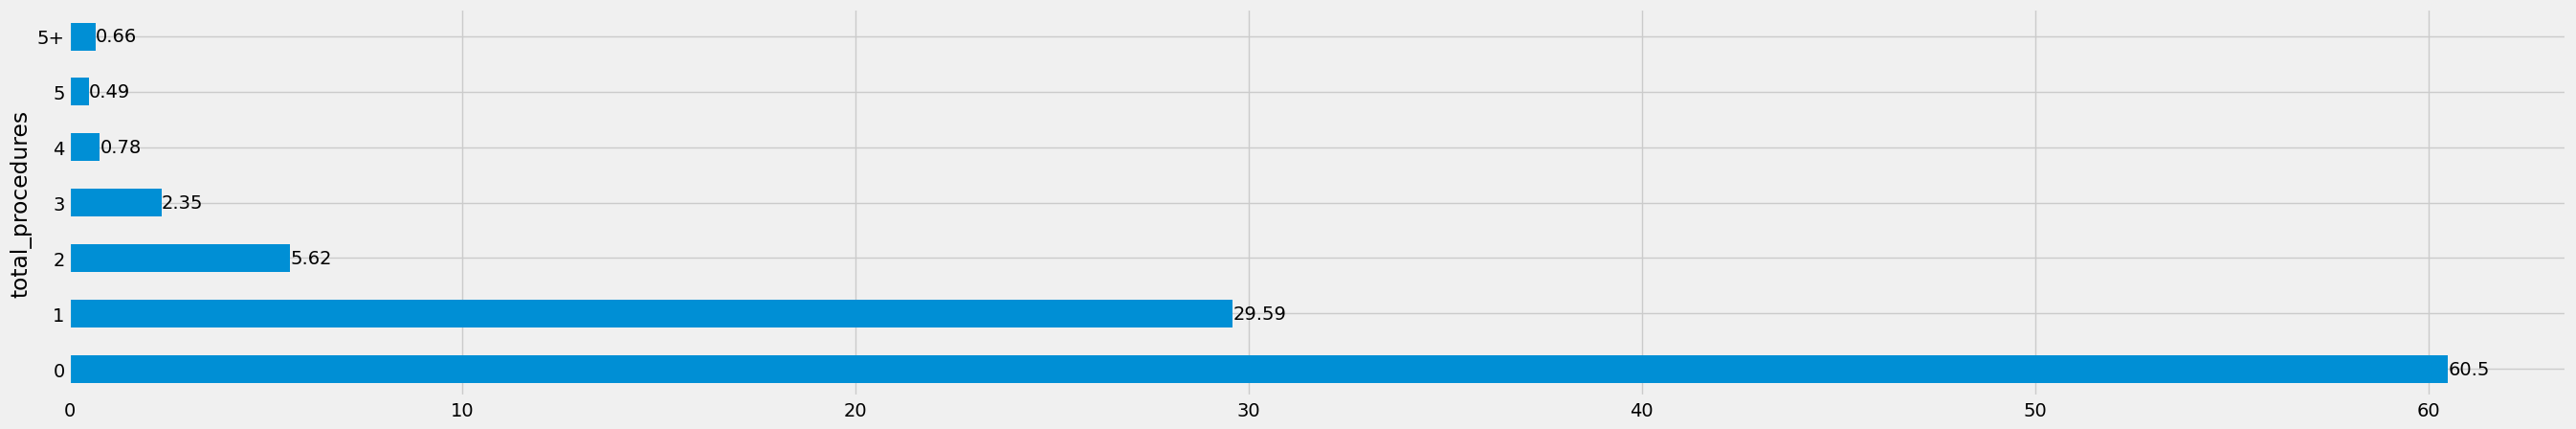

In [30]:
plt.figure(figsize=(30,5))
ax = data.groupby('total_procedures').size().div(len(data)).mul(100).round(2).plot(kind = 'barh')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

***
- **`60%` of encounter do not included with any kind of `procedures`**
***

**avg_procedure_cost**

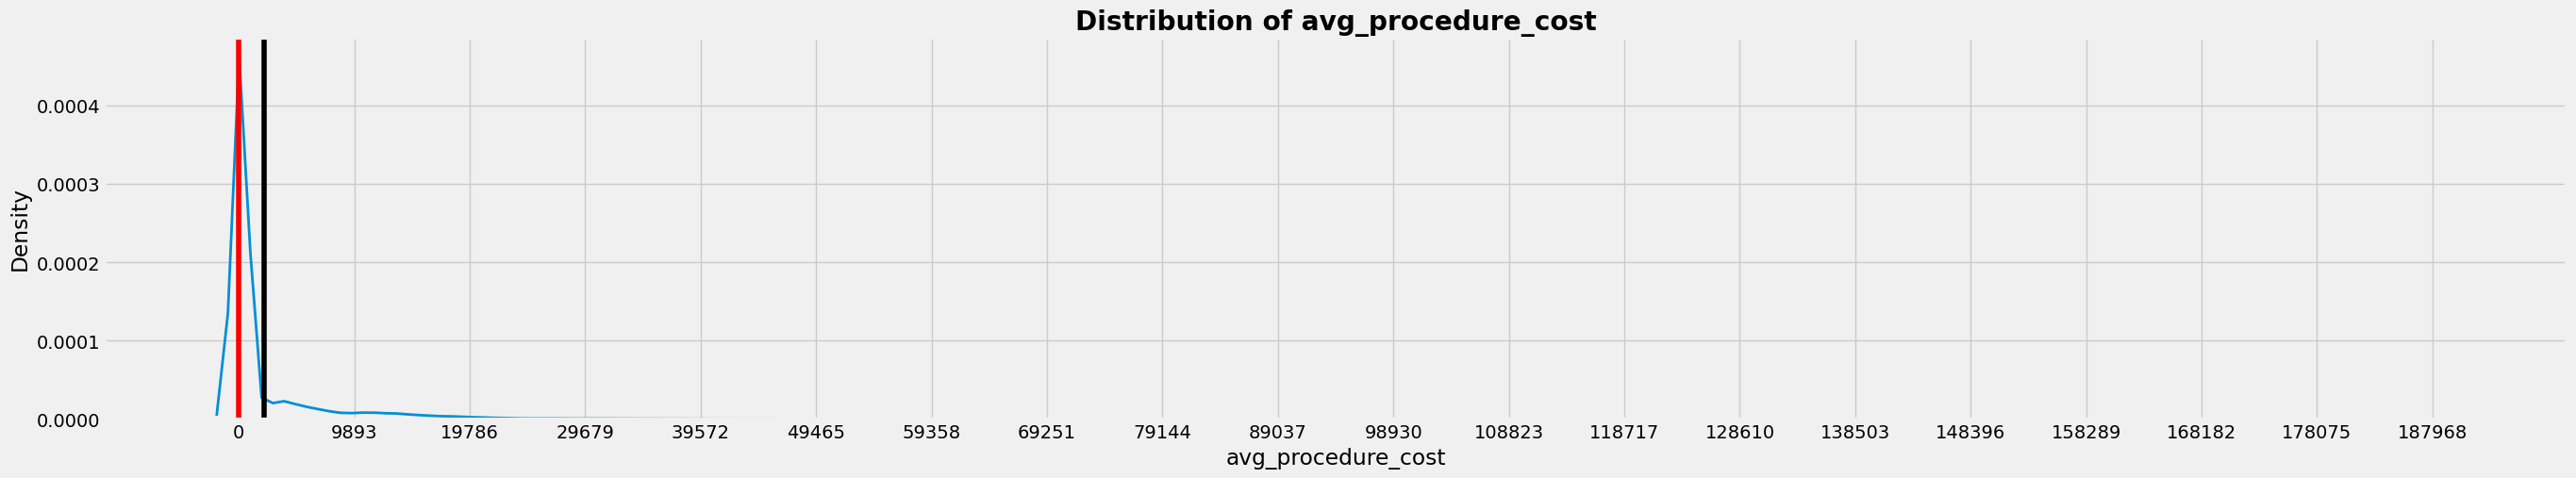

In [31]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'avg_procedure_cost',data= data,line_val=.50)
plt.axvline(data['avg_procedure_cost'].mean(),color = 'black')
plt.show()

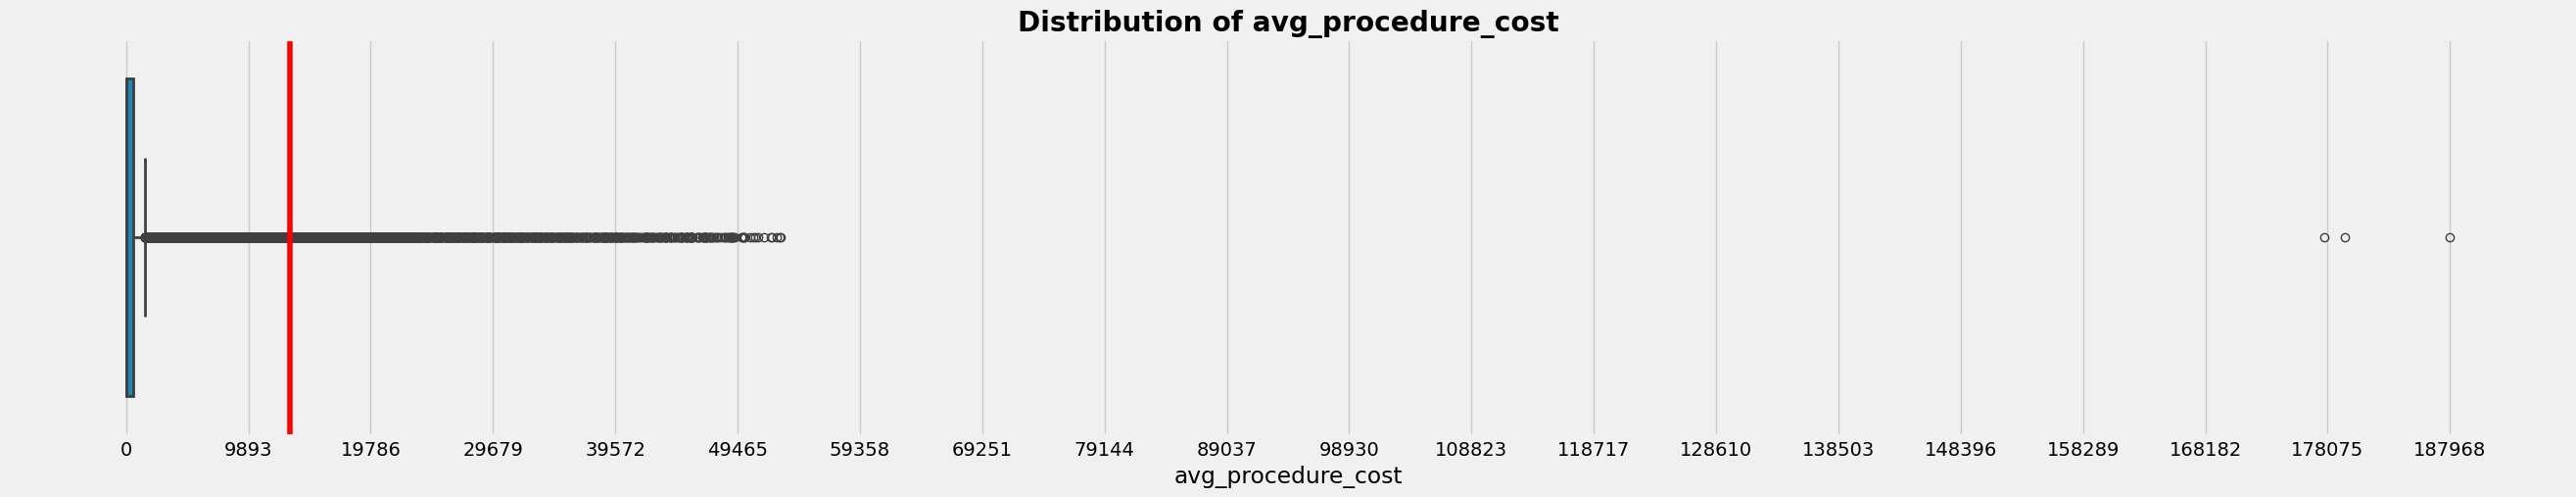

In [32]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'avg_procedure_cost',data= data)
plt.show()

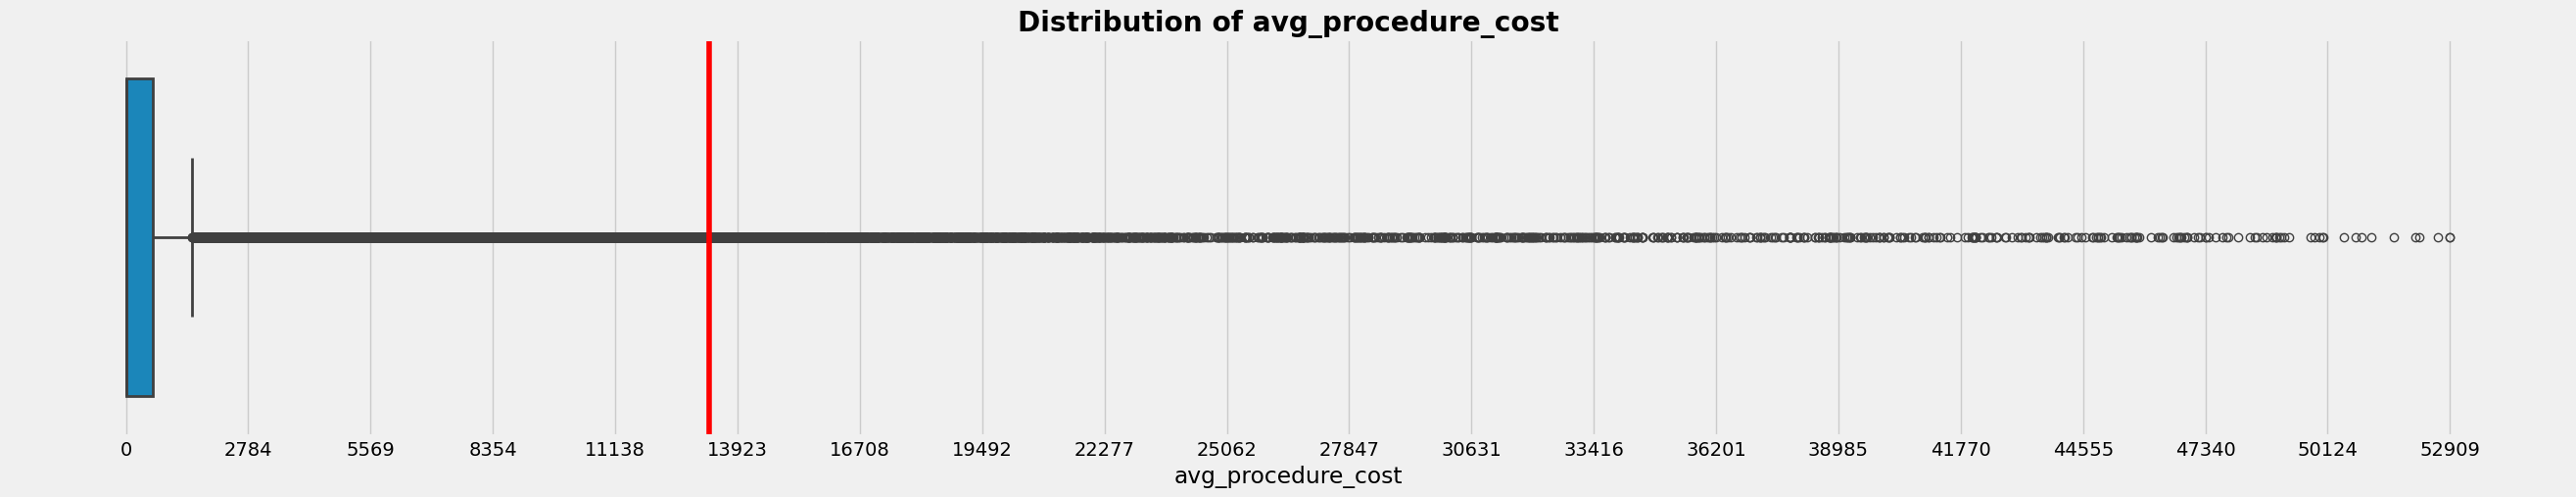

In [33]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'avg_procedure_cost',data= data[data['avg_procedure_cost'] < 100000])
plt.show()

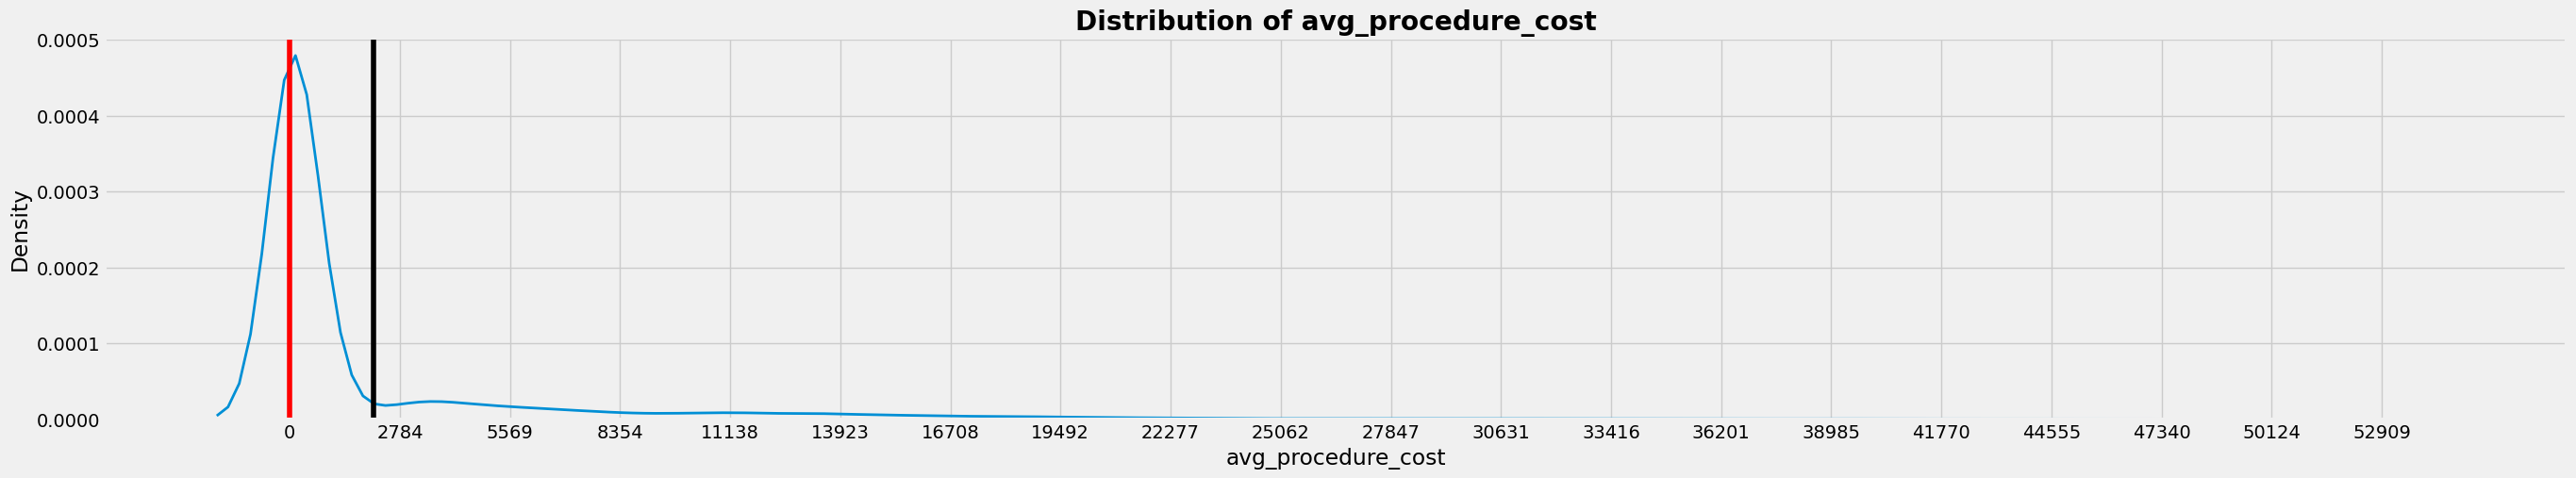

In [34]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'avg_procedure_cost',data= data[data['avg_procedure_cost'] < 100000],line_val=.50)
plt.axvline(data[data['avg_procedure_cost'] < 100000]['avg_procedure_cost'].mean(),color = 'black')
plt.show()

In [35]:
data[data['avg_procedure_cost'] > 100000]

encounter_start encounterclass base_encounter_cost  payer_coverage  \
3214  1991-06-21 20:51:21      INPATIENT              129.16             0.0   
4447  1993-08-18 16:26:18      INPATIENT              129.16             0.0   
9318  2014-09-13 15:02:20      INPATIENT              129.16             0.0   

     duration total_procedures  avg_procedure_cost  total_medicines  \
3214   1_week                1           187968.69                0   
4447   1_week                1           177834.83                0   
9318   1_week                1           179470.09                0   

      avg_base_medicine_cost  avg_total_medicine_cost  \
3214                     0.0                      0.0   
4447                     0.0                      0.0   
9318                     0.0                      0.0   

      reasons_for_medications  is_ongoing_condition  total_conditions  \
3214                        0                    -1                 0   
4447                        0                    -1                 0   
9318                        0                    -1                 0   

      is_ongoing_careplan  total_careplans  age_as_2022  marital   race  \
3214                   -1                0           54  MARRIED  BLACK   
4447                   -1                0           41   SINGLE  WHITE   
9318                   -1                0           67   SINGLE  WHITE   

        ethnicity patient_gender provider_gender  utilization  \
3214  NONHISPANIC              F               F         1314   
4447  NONHISPANIC              M               M         1643   
9318     HISPANIC              M               F         2225   

      caused_readmission  condition_duration  careplan_duration  
3214                   0                   0                  0  
4447                   1                   0                  0  
9318                   1                   0                  0

In [36]:
data[data['avg_procedure_cost'] < 100000]['avg_procedure_cost'].describe().round(2)

count    53343.00
mean      2119.35
std       5431.67
min          0.00
25%          0.00
50%          0.00
75%        601.96
max      52909.50
Name: avg_procedure_cost, dtype: float64

In [37]:
data['avg_procedure_cost'].describe().round(2)

count     53346.00
mean       2129.45
std        5596.18
min           0.00
25%           0.00
50%           0.00
75%         602.04
max      187968.69
Name: avg_procedure_cost, dtype: float64

***
- **There are 3 `extreme outliers` in `avg_procedure_cost` column, and data is skewed towards right**
***

**total_medicines**

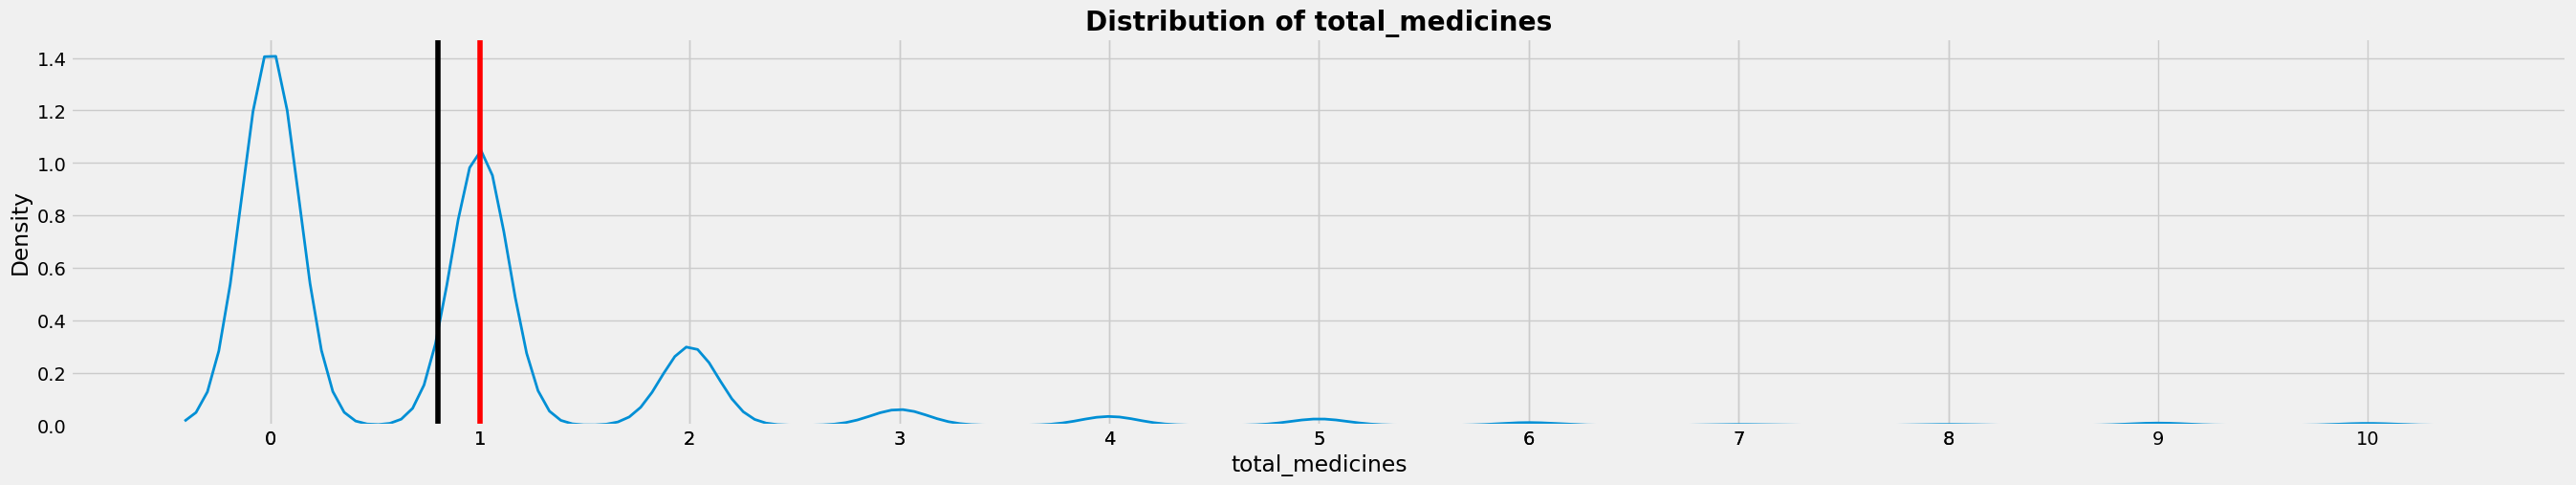

In [38]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'total_medicines',data= data,line_val=.50)
plt.axvline(data['total_medicines'].mean(),color = 'black')
plt.show()

In [39]:
temp = data.groupby('total_medicines').size().reset_index(name = 'values')
temp['cumsum'] = np.cumsum(temp['values'])
temp

total_medicines  values  cumsum
0                 0   26077   26077
1                 1   19062   45139
2                 2    5463   50602
3                 3    1095   51697
4                 4     613   52310
5                 5     441   52751
6                 6     190   52941
7                 7      58   52999
8                 8      61   53060
9                 9     154   53214
10               10     132   53346

In [40]:
data['total_medicines']=data['total_medicines'].apply(lambda x: '5+' if (x>5)  else str(x))

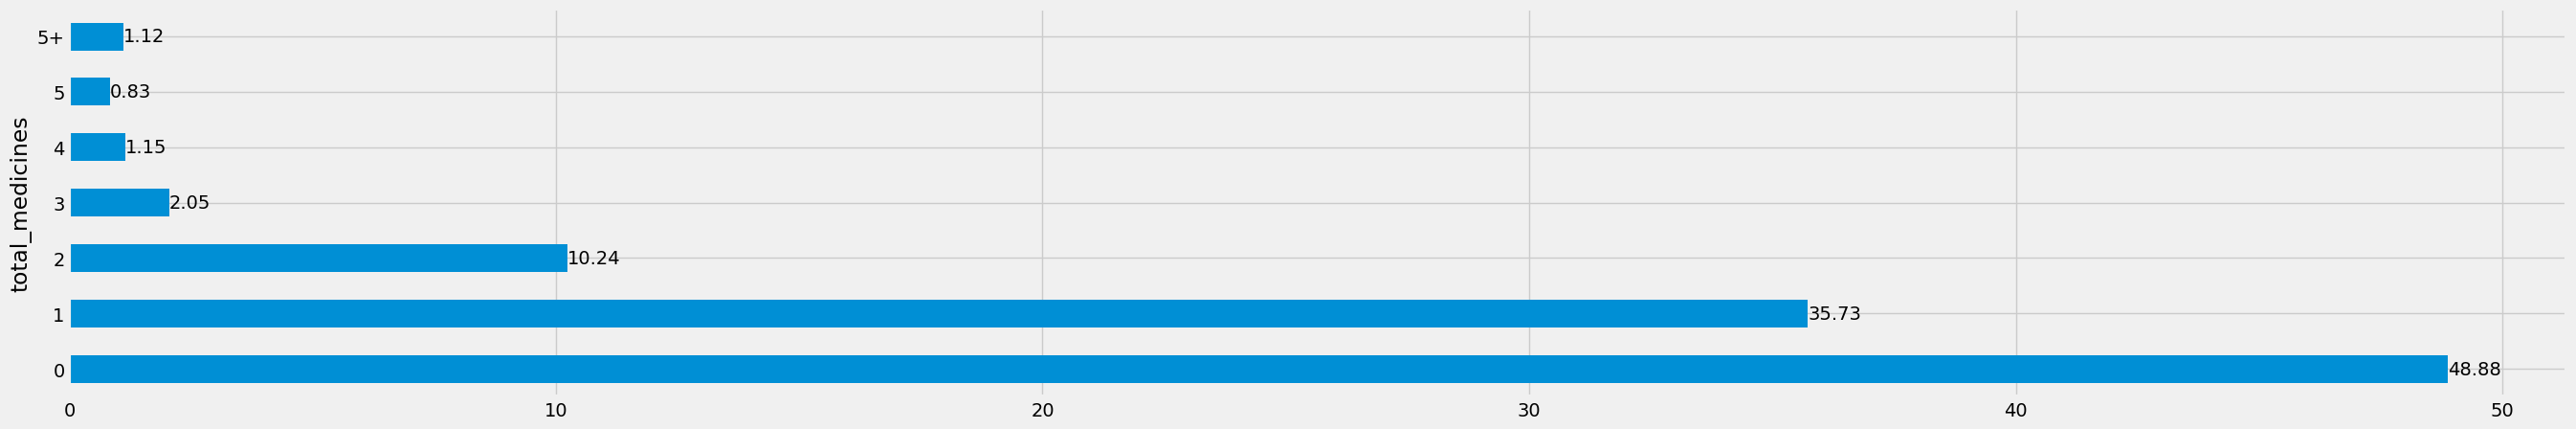

In [41]:
plt.figure(figsize=(30,5))
ax = data.groupby('total_medicines').size().div(len(data)).mul(100).round(2).plot(kind = 'barh')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

***
- **nearly half the times, total medicine `0` occurs**
***

**avg_base_medicine_cost**

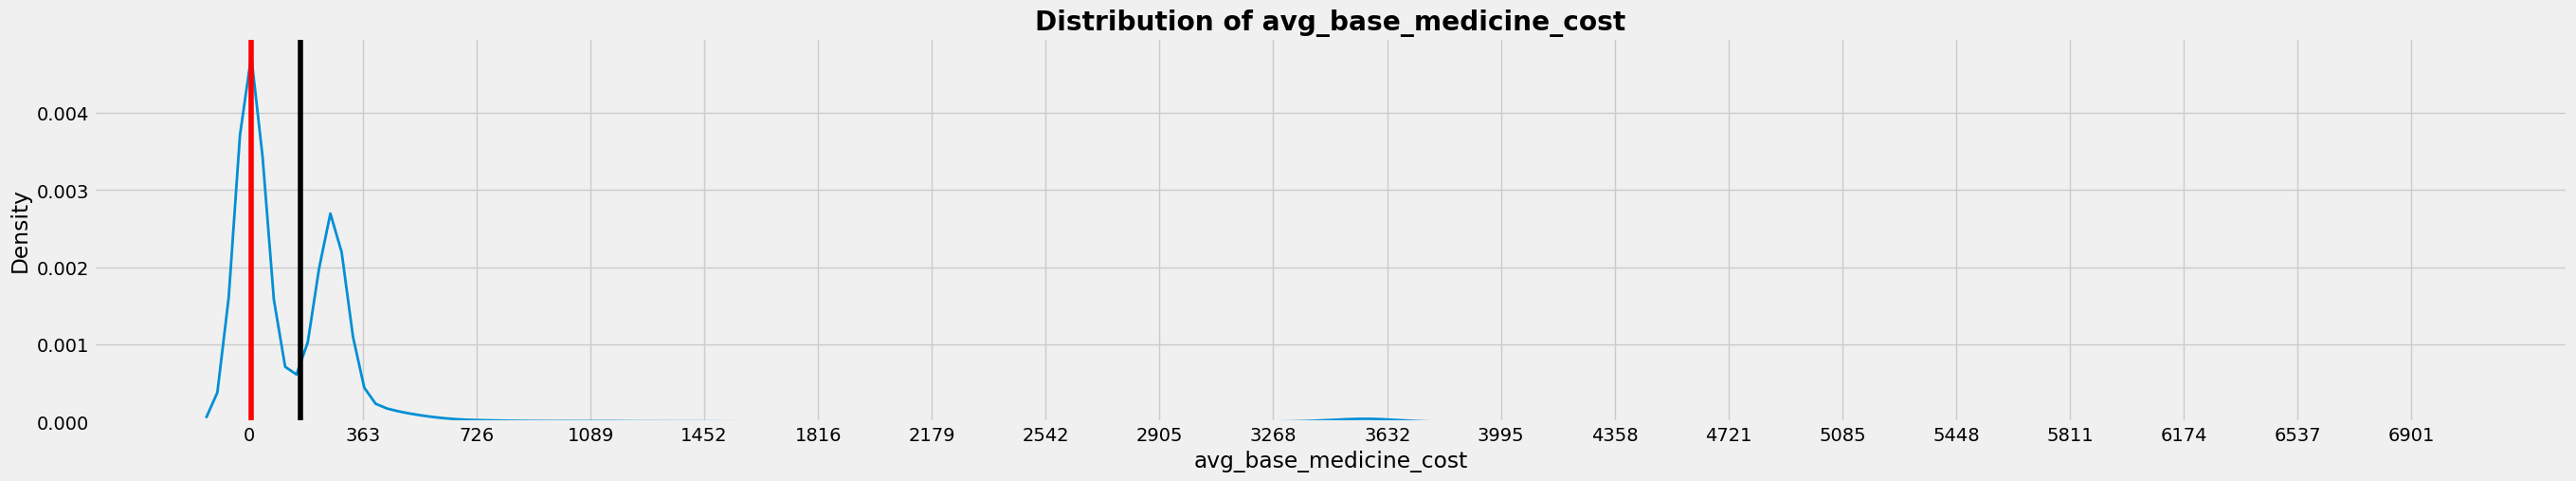

In [42]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'avg_base_medicine_cost',data= data,line_val=.50)
plt.axvline(data['avg_base_medicine_cost'].mean(),color = 'black')
plt.show()

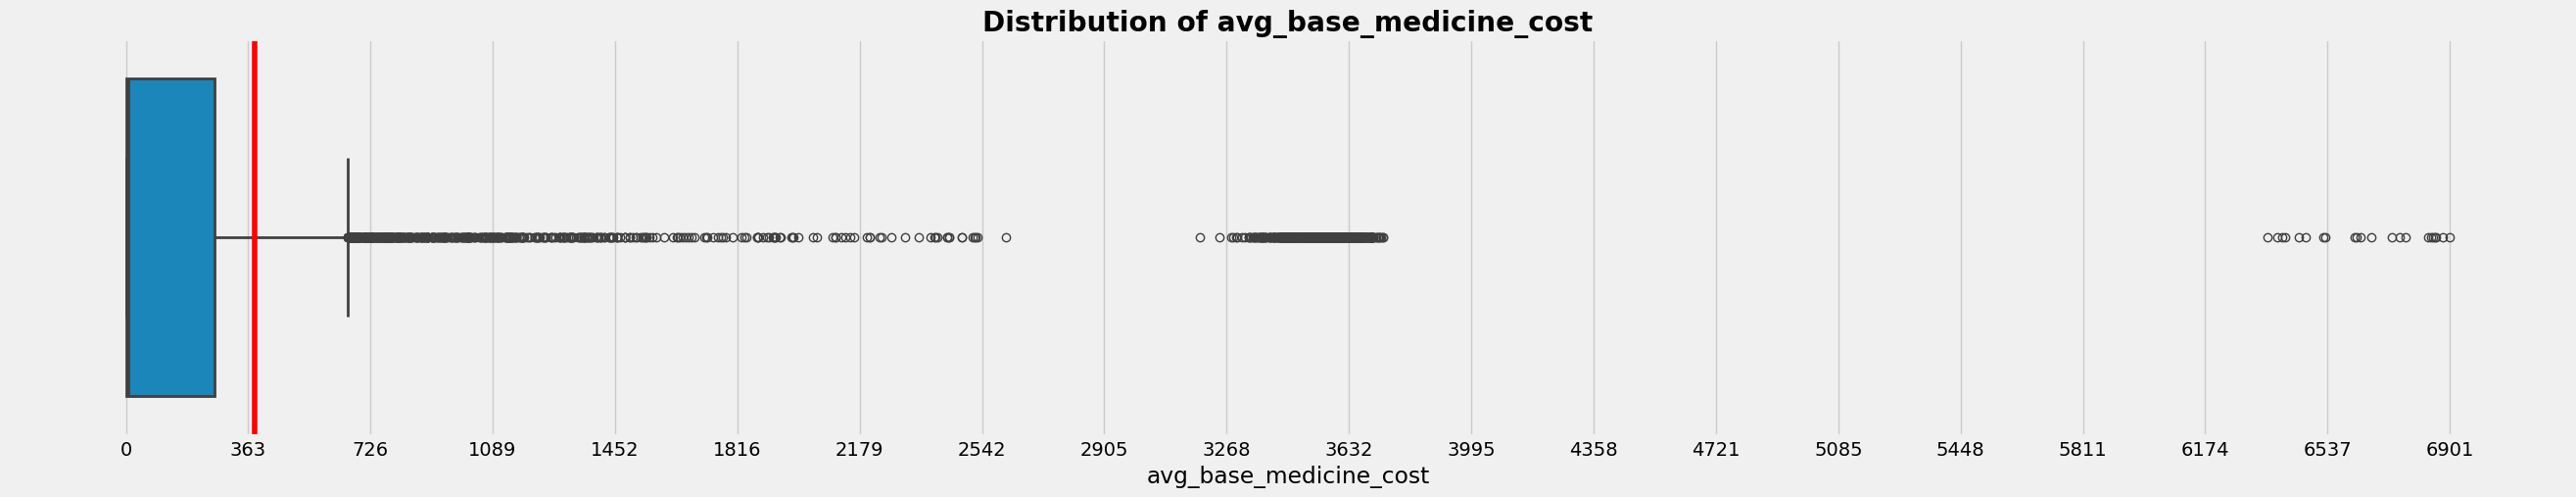

In [43]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'avg_base_medicine_cost',data= data)
plt.show()

- **There are outliers in 2 separate groups**

**avg_total_medicine_cost**

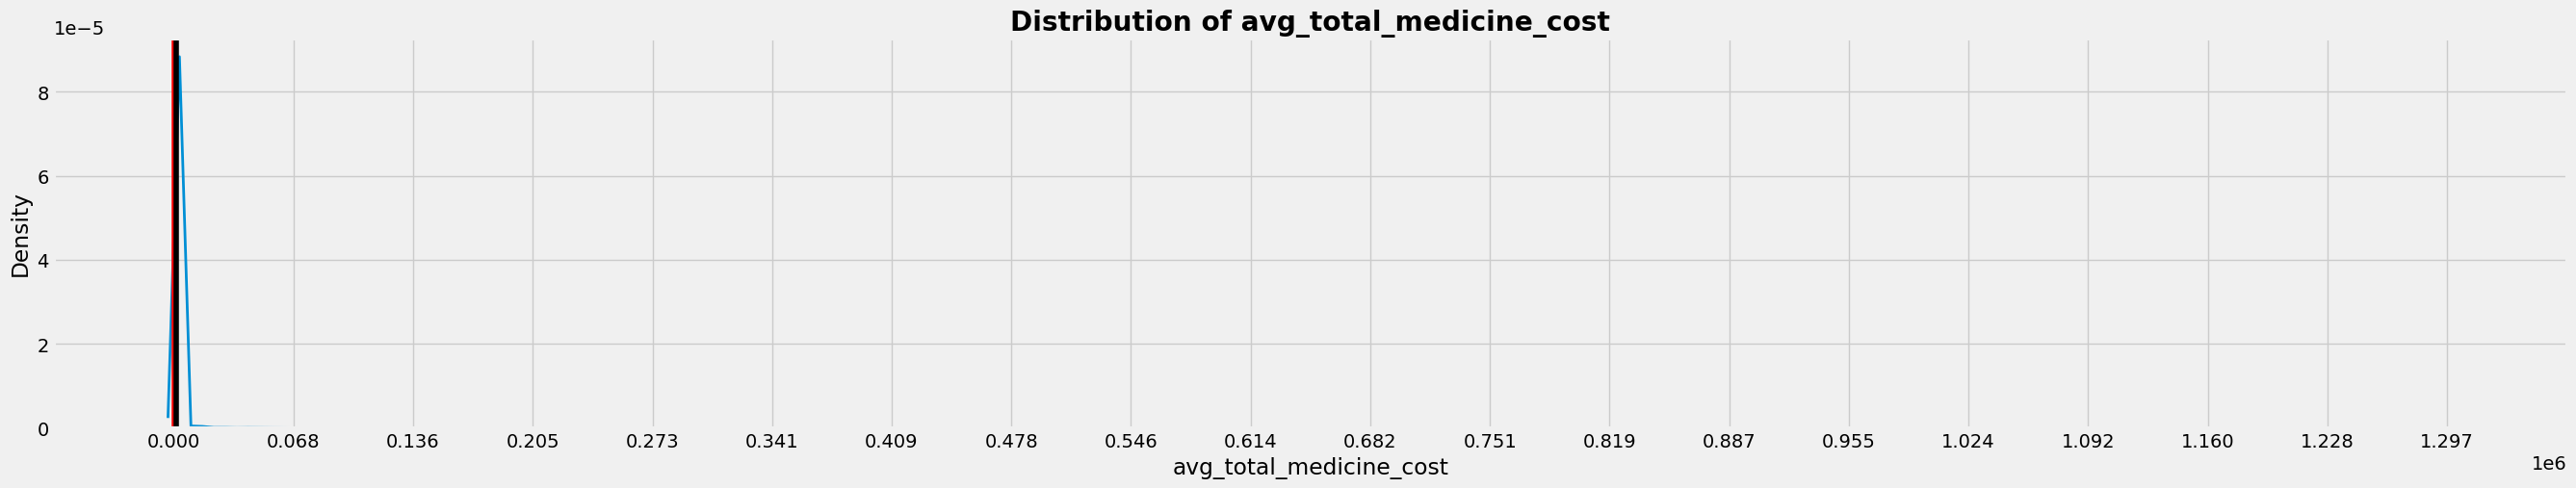

In [44]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'avg_total_medicine_cost',data= data,line_val=.50)
plt.axvline(data['avg_total_medicine_cost'].mean(),color = 'black')
plt.show()

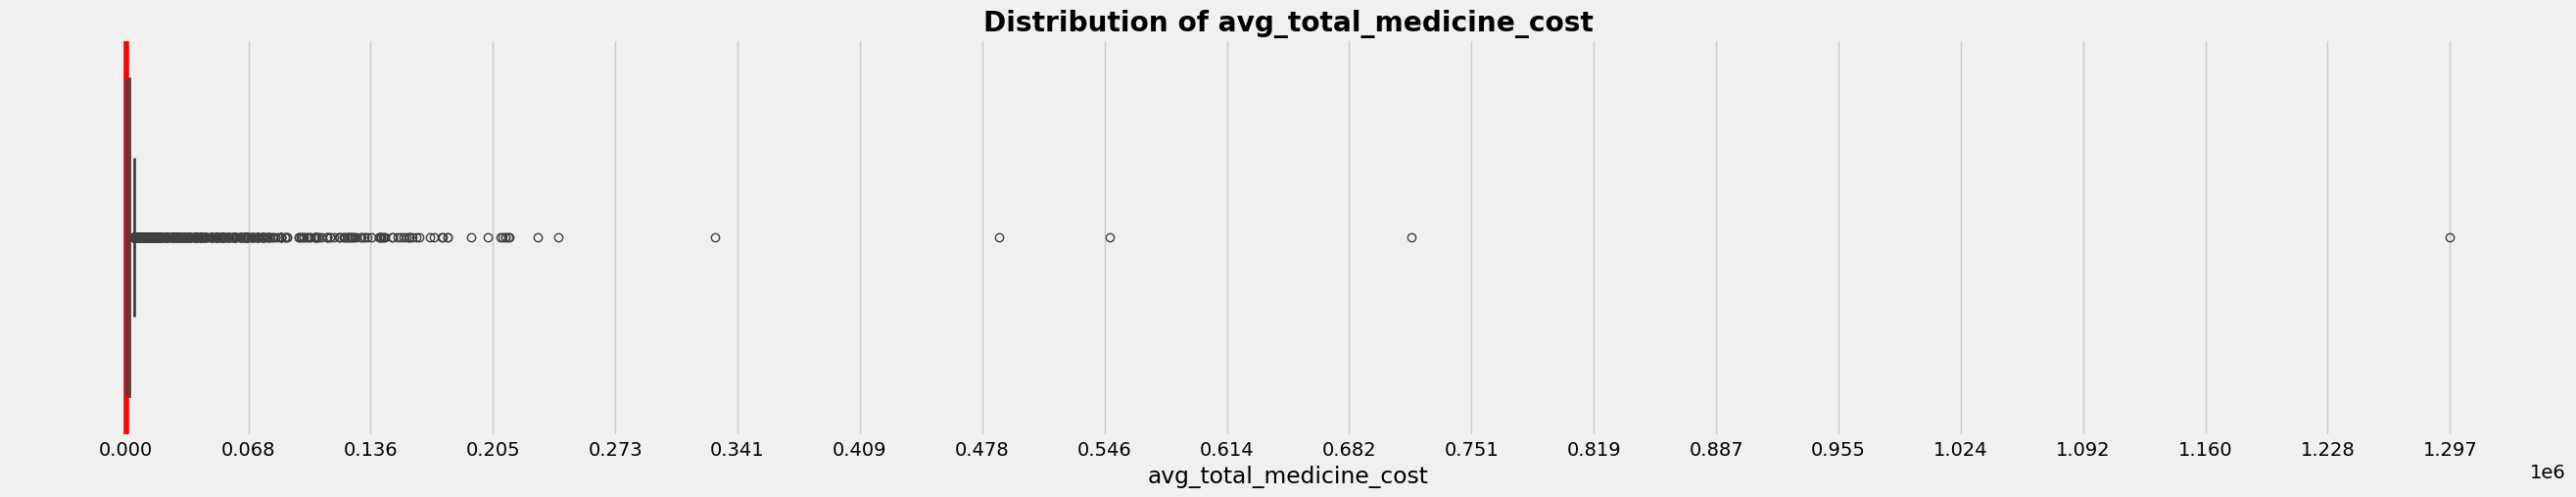

In [45]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'avg_total_medicine_cost',data= data,line_val=.50)
plt.show()

- **There are some extreme outliers**

**reasons_for_medications**

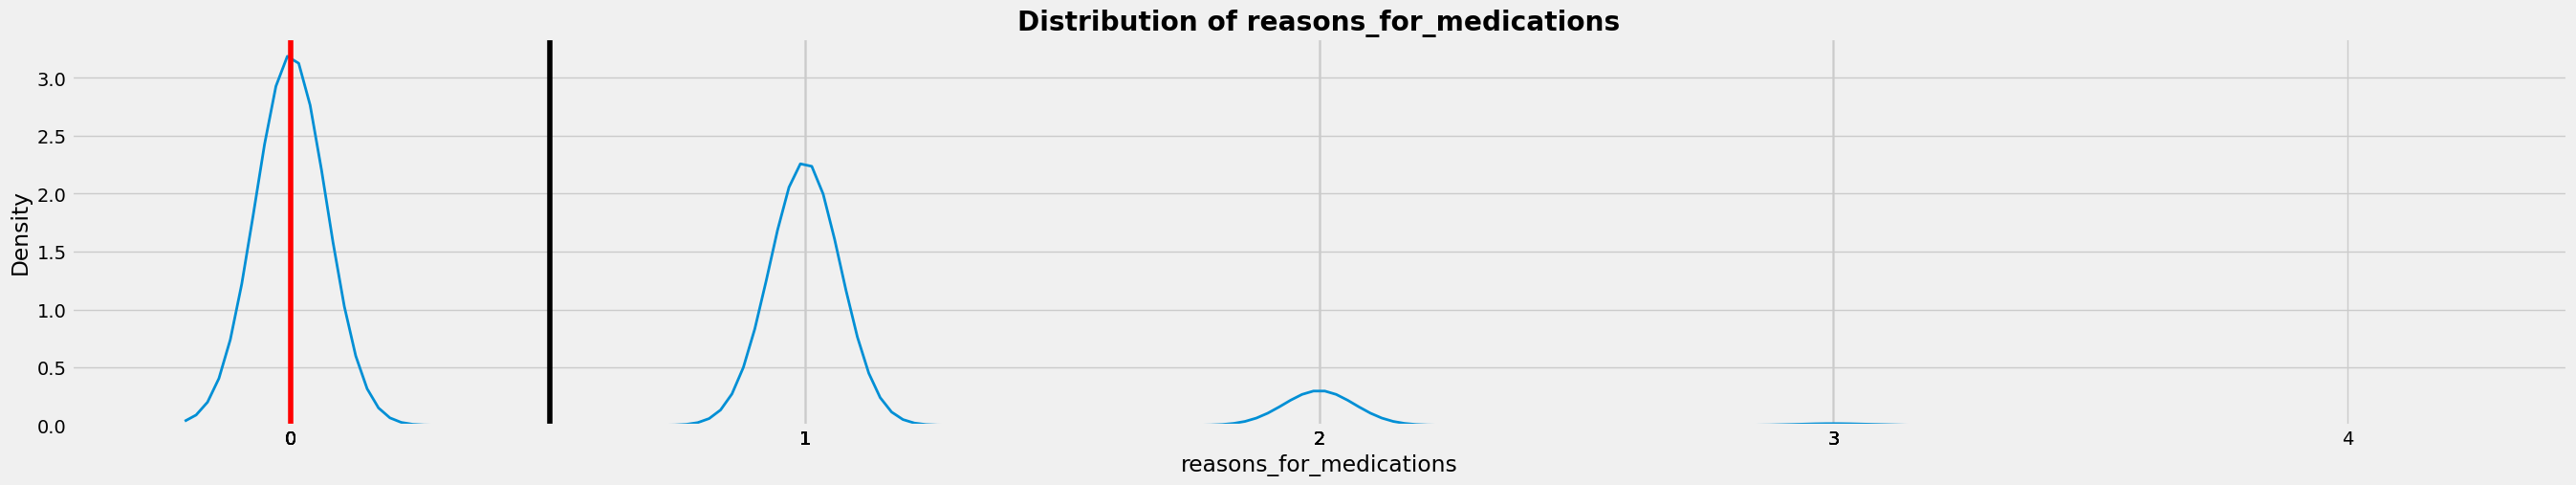

In [46]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'reasons_for_medications',data= data,line_val=.50)
plt.axvline(data['reasons_for_medications'].mean(),color = 'black')
plt.show()

In [47]:
data.groupby('reasons_for_medications').size()

reasons_for_medications
0    29485
1    20967
2     2758
3      135
4        1
dtype: int64

In [48]:
data['reasons_for_medications']=data['reasons_for_medications'].apply(lambda x: '2+' if (x>2)  else str(x))

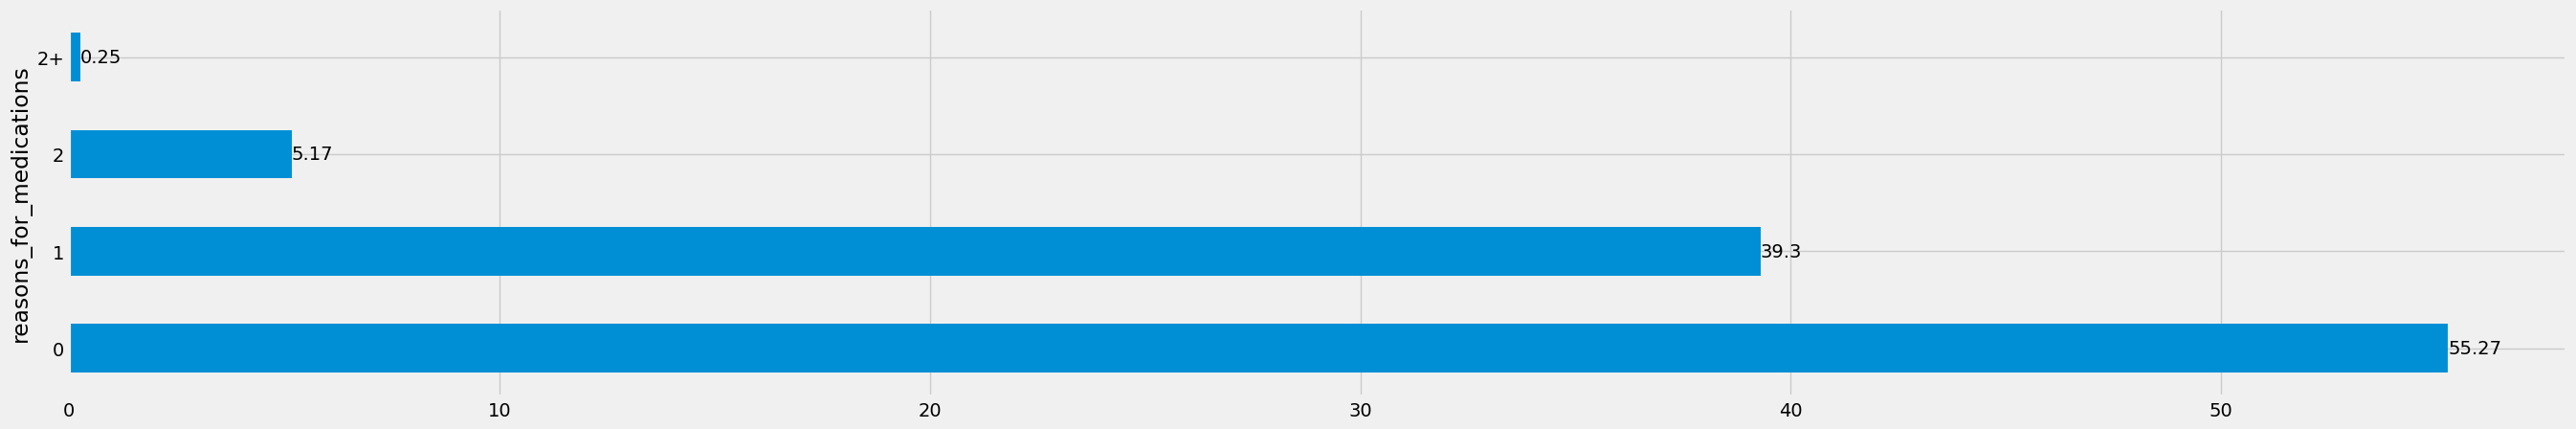

In [49]:
plt.figure(figsize=(30,5))
ax = data.groupby('reasons_for_medications').size().div(len(data)).mul(100).round(2).plot(kind = 'barh')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

- **for almost half of the observation have 0 medications reason**

**is_ongoing_condition**

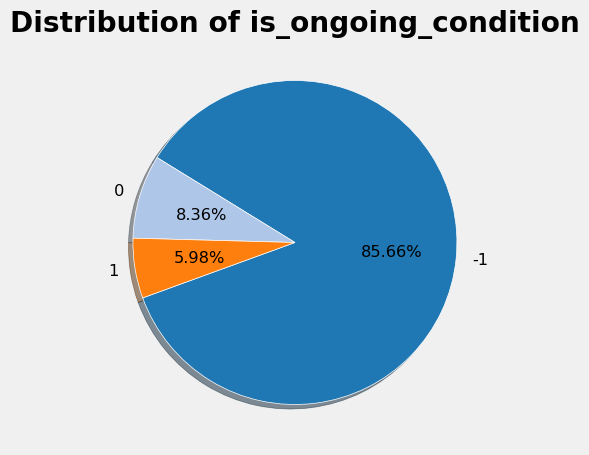

In [50]:
plt.figure(figsize=(5,5))
P.plot_pie(column='is_ongoing_condition',data = data)
plt.show()

In [51]:
data['is_ongoing_condition']=np.where(data['is_ongoing_condition'] == 1, 'YES',np.where(data['is_ongoing_condition']== 0,'FINISHED','NOTHING'))

***
- **`is_ongoing_condition` have `nothing` as most frequent values, and `ongoing` have the least value**
***

**total_conditions**

In [52]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'total_conditions',data= data,line_val=.50)
plt.show()

In [53]:
data.groupby('total_conditions').size()

total_conditions
0    45696
1     7066
2      468
3       96
4       16
5        3
7        1
dtype: int64

In [54]:
data['total_conditions']=data['total_conditions'].apply(lambda x: '1+' if (x>1)  else str(x))

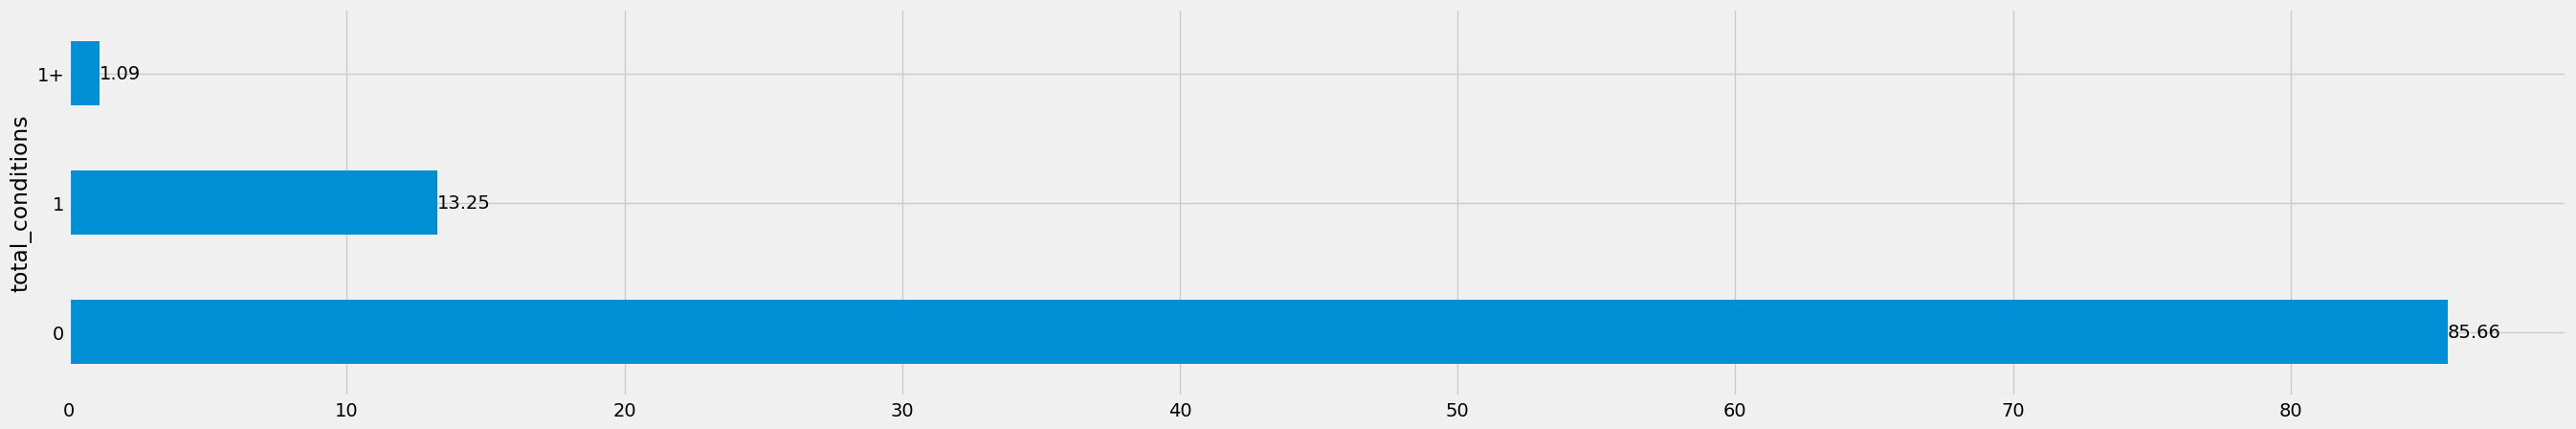

In [55]:
plt.figure(figsize=(30,5))
ax = data.groupby('total_conditions').size().div(len(data)).mul(100).round(2).plot(kind = 'barh')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

***
- **in about `85%` of `observations` have `total conditions` as `0`**
***

**is_ongoing_careplan**

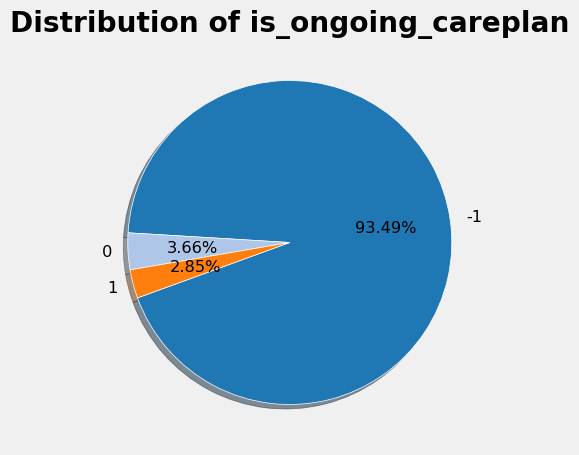

In [56]:
plt.figure(figsize=(5,5))
P.plot_pie(column='is_ongoing_careplan',data = data)
plt.show()

In [57]:
data['is_ongoing_careplan']=np.where(data['is_ongoing_careplan'] == 1, 'YES',np.where(data['is_ongoing_careplan']== 0,'FINISHED','NOTHING'))

In [58]:
plt.figure(figsize=(5,5))
P.plot_pie(column='is_ongoing_careplan',data = data)
plt.show()

- **more than 90% of observations have nothing value**

**total_careplans**

In [59]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'total_careplans',data= data,line_val=.50)
plt.show()

In [60]:
data.groupby('total_careplans').size()

total_careplans
0    49874
1     3461
2       11
dtype: int64

In [61]:
data['total_careplans']=data['total_careplans'].astype('object')

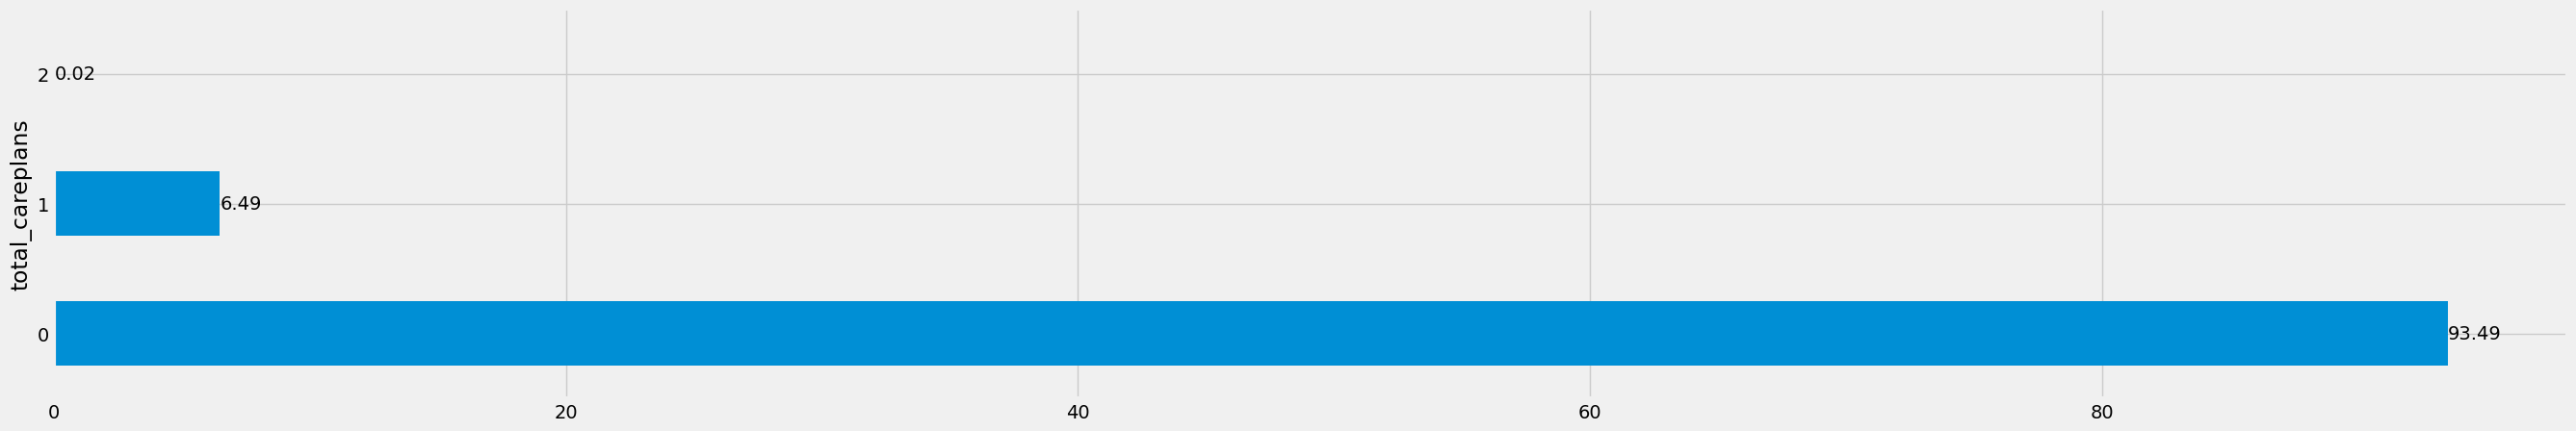

In [62]:
plt.figure(figsize=(30,5))
ax = data.groupby('total_careplans').size().div(len(data)).mul(100).round(2).sort_values(ascending=False).plot(kind = 'barh')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

**age_as_2022**

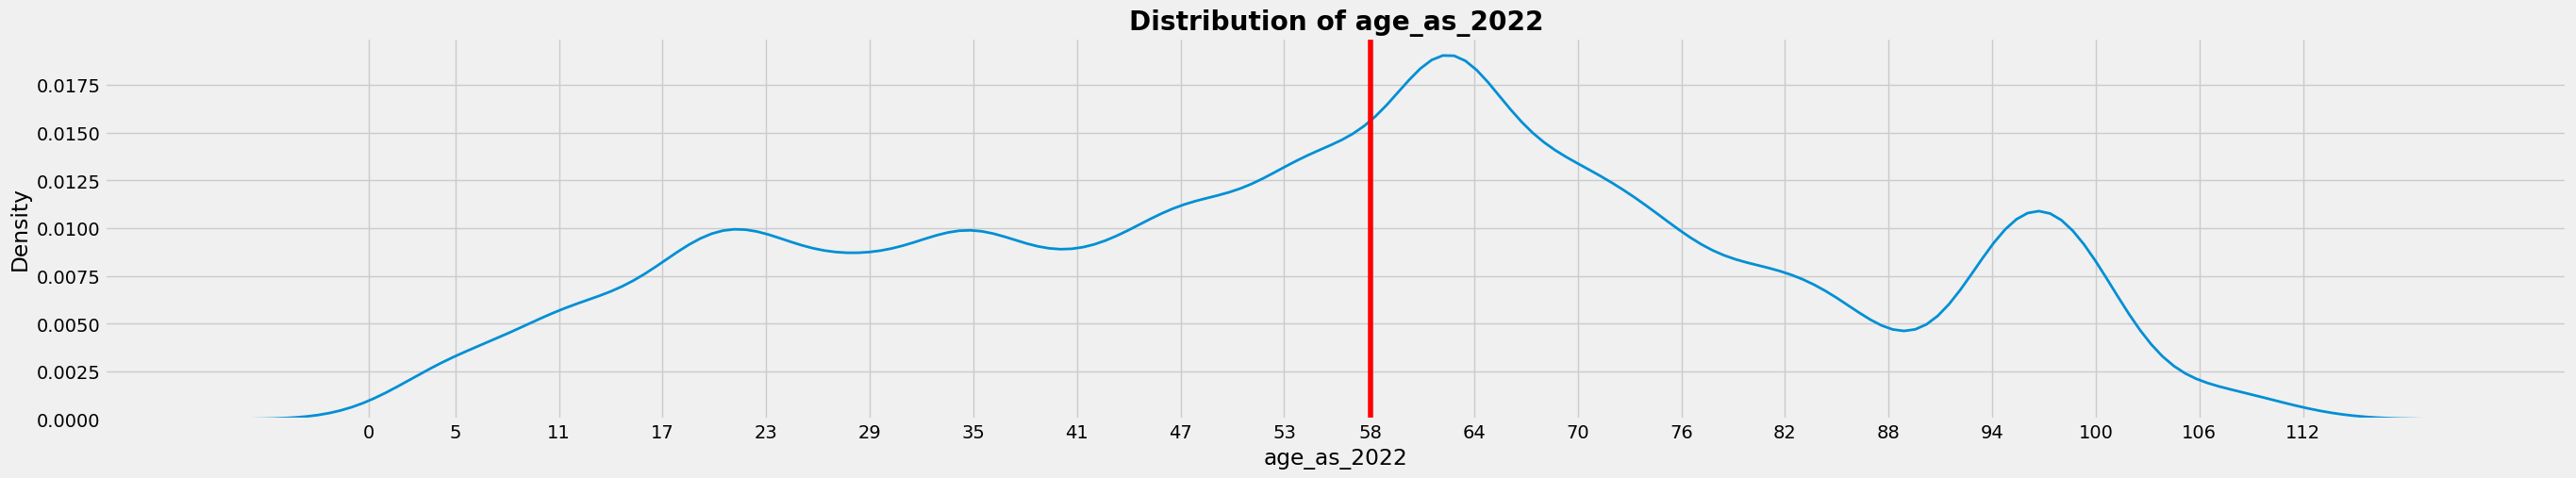

In [63]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'age_as_2022',data= data,line_val=.50)
plt.show()

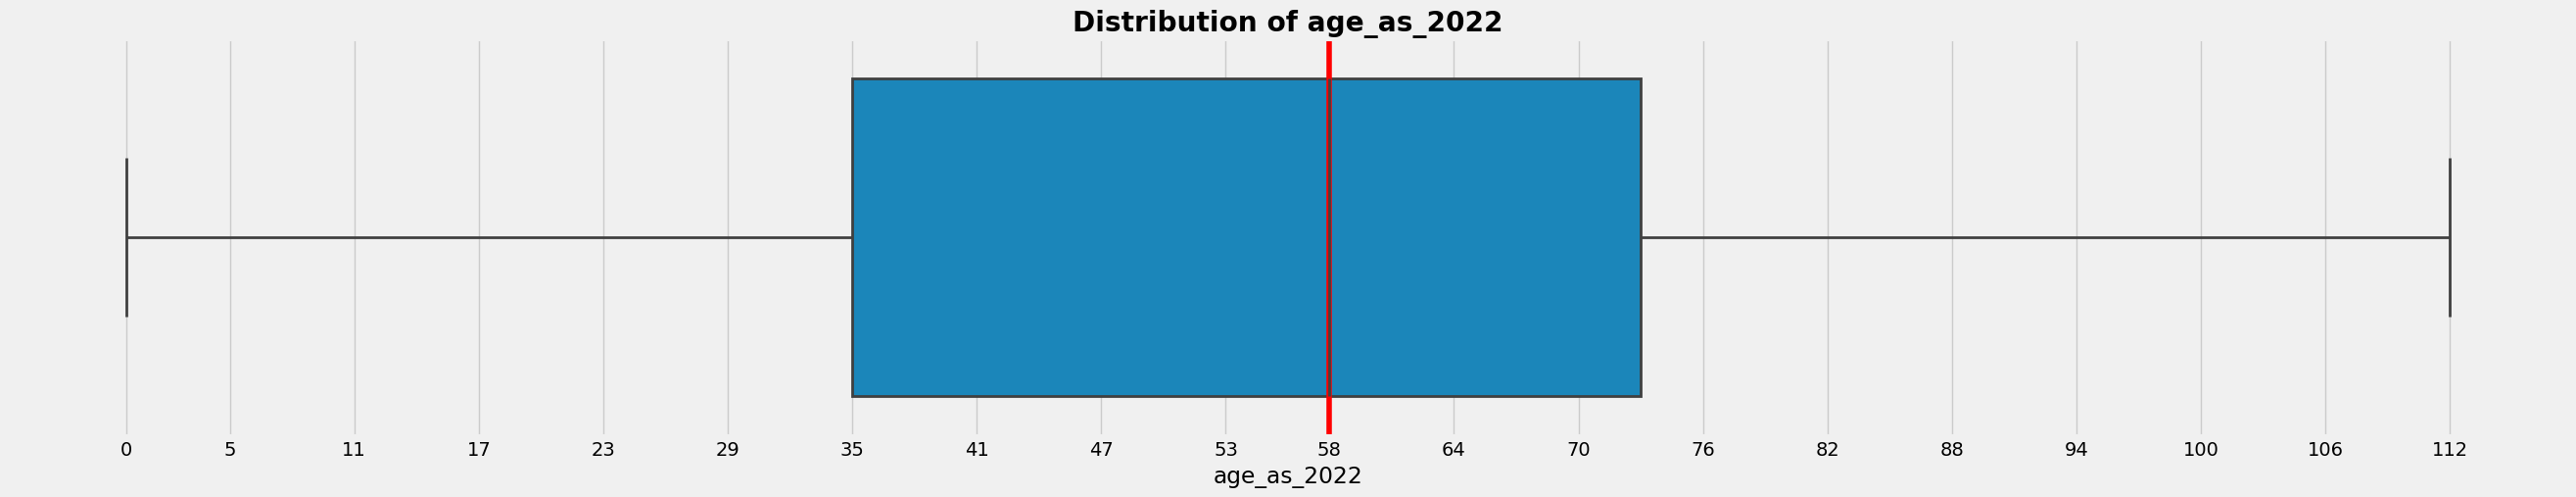

In [64]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'age_as_2022',data= data,line_val=.50)
plt.show()

- **age column do not have outliers, and there is a small peak at around 100**

**marital**

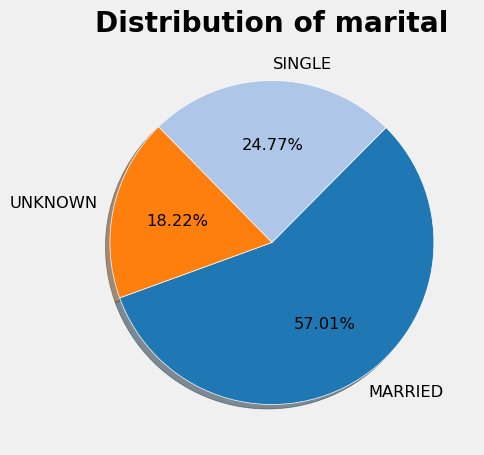

In [65]:
plt.figure(figsize=(5,5))
P.plot_pie(column='marital',data = data)
plt.show()

- **more than 50% of observations have value as married**

**race**

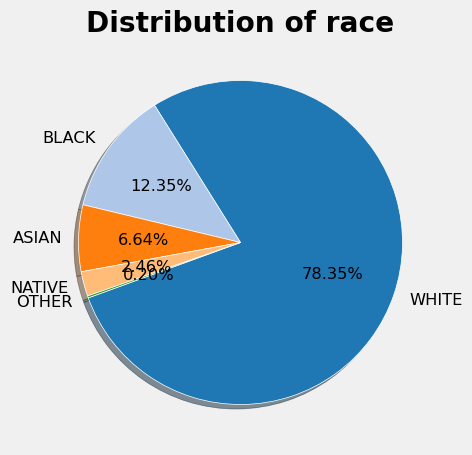

In [66]:
plt.figure(figsize=(5,5))
P.plot_pie(column='race',data = data)
plt.show()

- **approx 79% of observations are from white race**

**ethnicity**

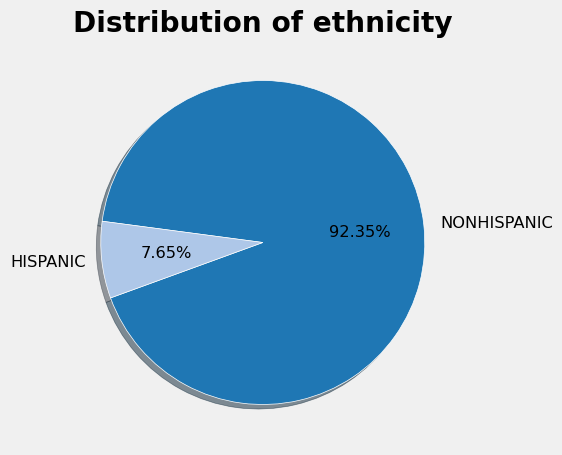

In [67]:
plt.figure(figsize=(5,5))
P.plot_pie(column='ethnicity',data = data)
plt.show()

- **more than 90% of observations are from non hispanic ethnicity**

**patient_gender**

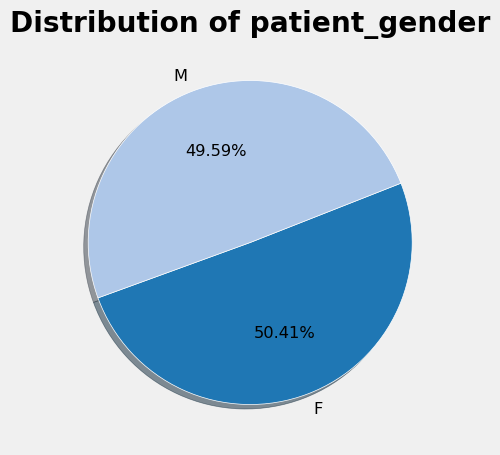

In [68]:
plt.figure(figsize=(5,5))
P.plot_pie(column='patient_gender',data = data)
plt.show()

- **patient gender is almost equally distributed**

**provider_gender**

In [69]:
plt.figure(figsize=(5,5))
P.plot_pie(column='provider_gender',data = data)
plt.show()

- **more female provider gender compared to male gender**

**utilization**

In [70]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'utilization',data= data,line_val=.50)
plt.show()

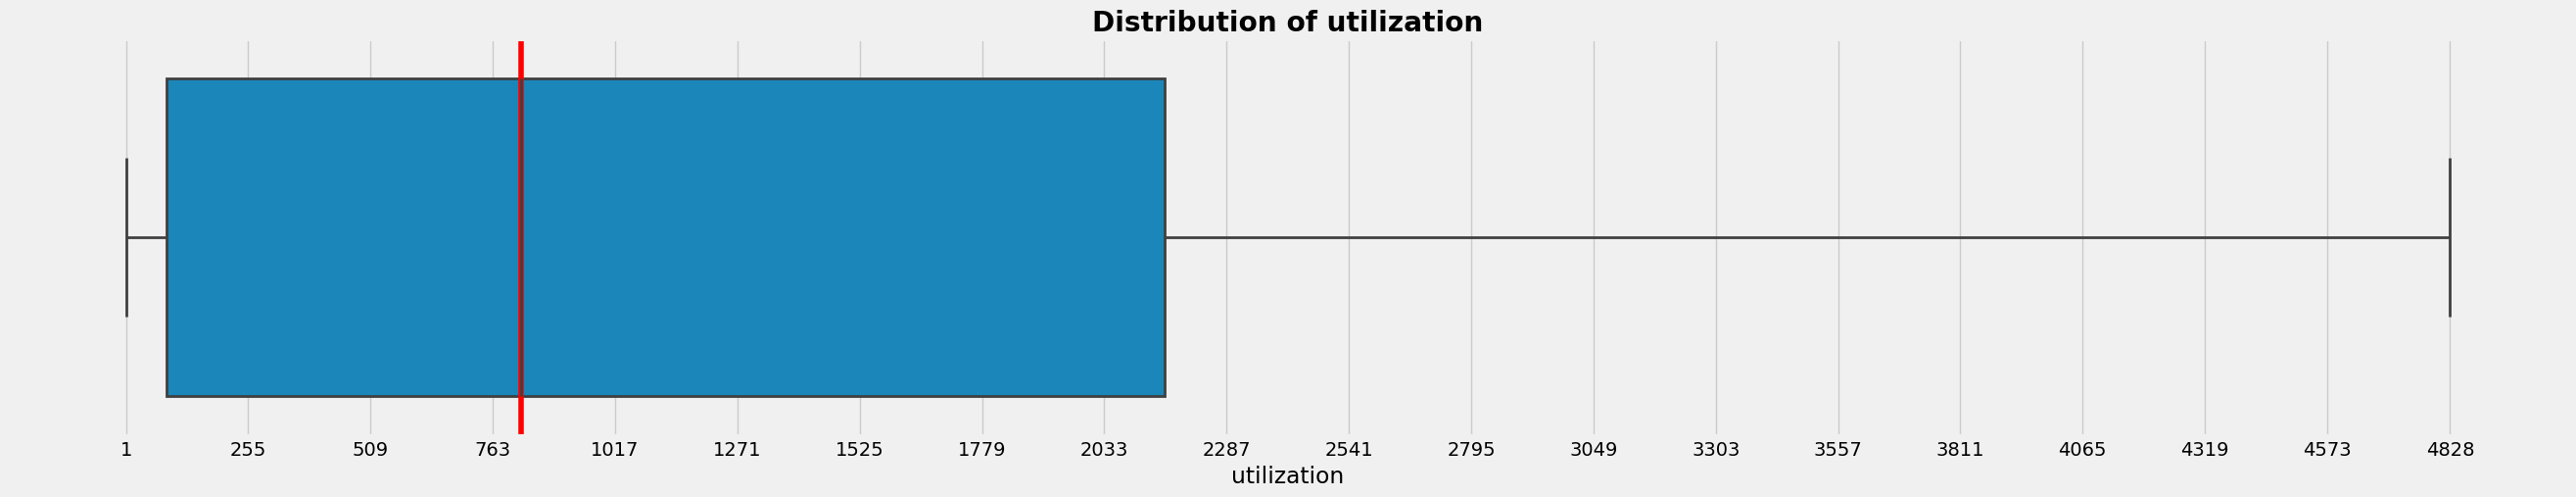

In [71]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'utilization',data= data,line_val=.50)
plt.show()

- **utilization column do not have outlier, but values are more around the lower end**

**caused_readmission**

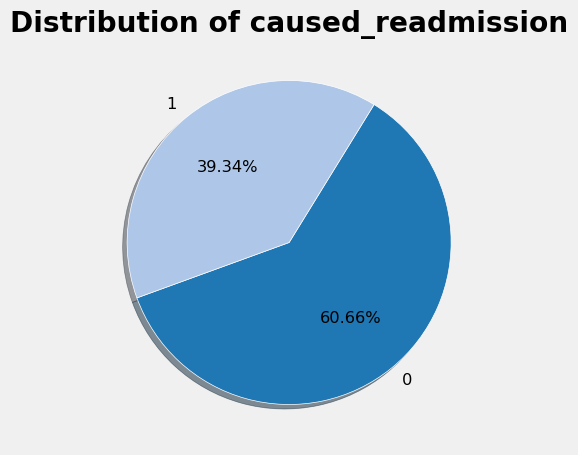

In [72]:
plt.figure(figsize=(5,5))
P.plot_pie(column='caused_readmission',data = data)
plt.show()

***
- **`almost` `40%` of encounter are reason for `readmissions`**
***

**condition_duration**

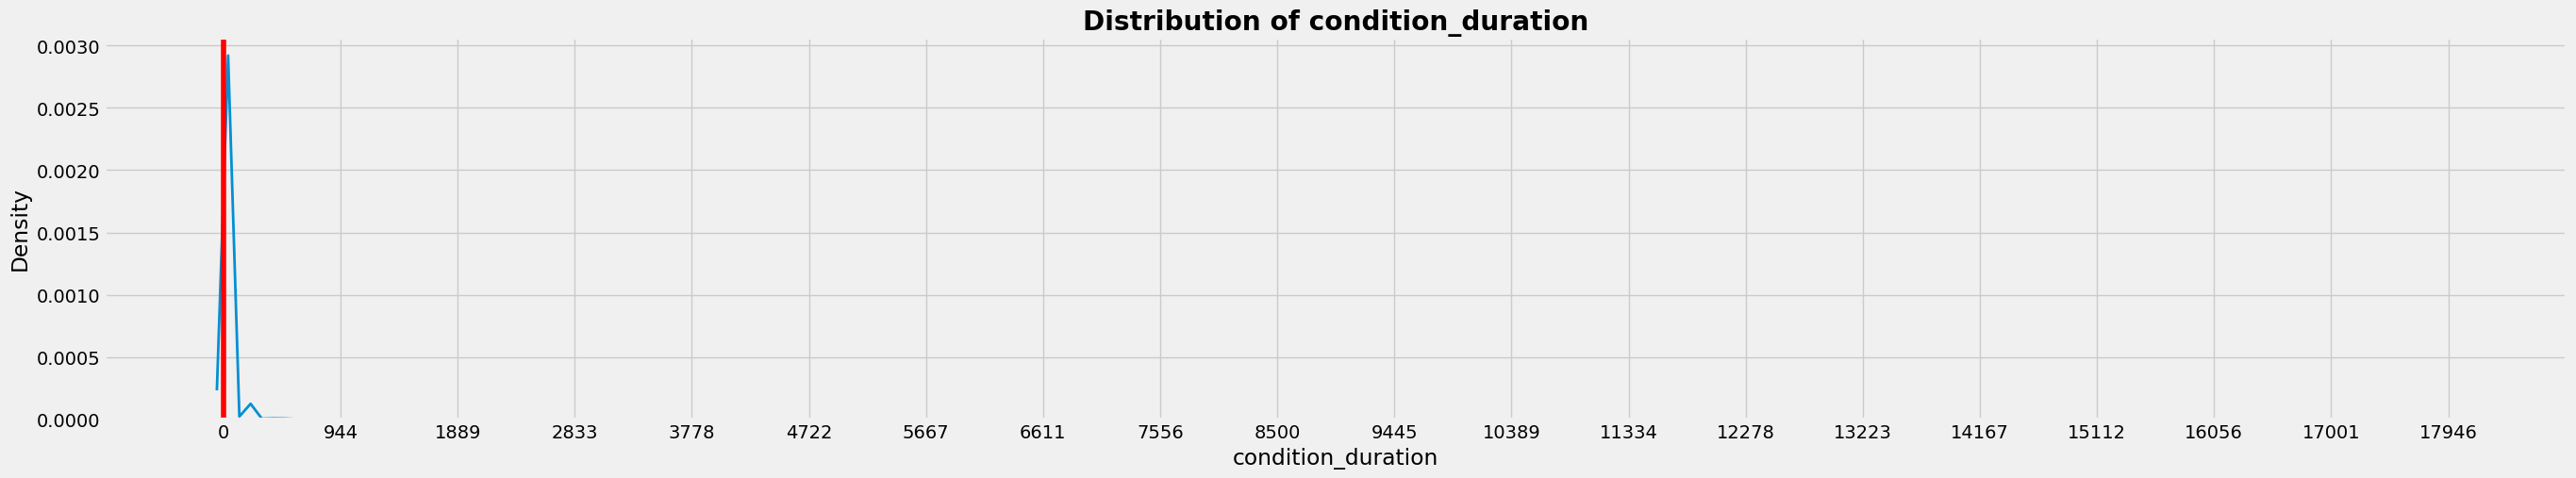

In [73]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'condition_duration',data= data,line_val=.50)
plt.show()

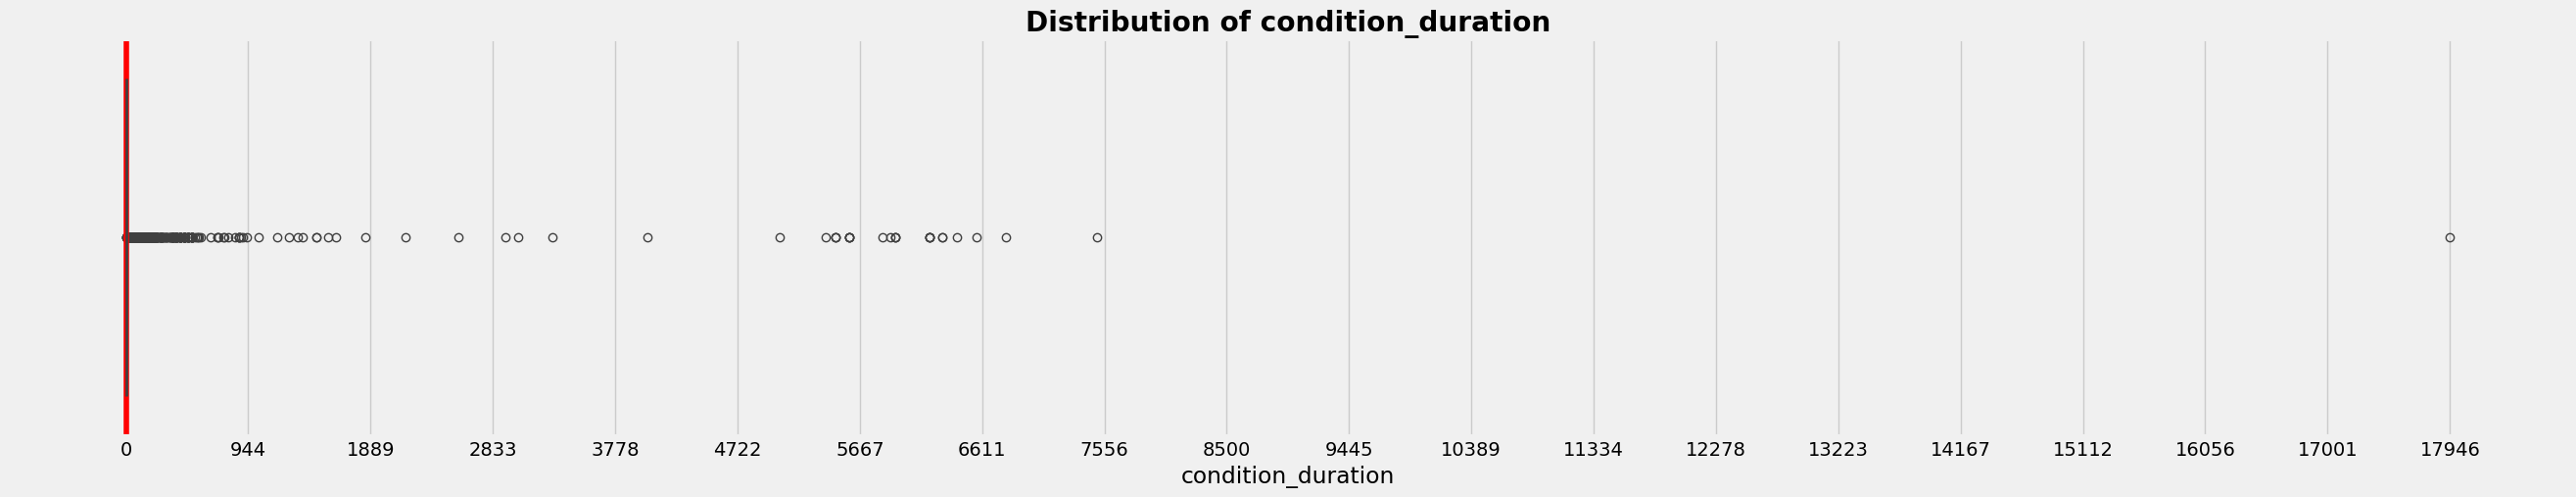

In [74]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'condition_duration',data= data,line_val=.50)
plt.show()

- **too many outiers**

**careplan_duration**

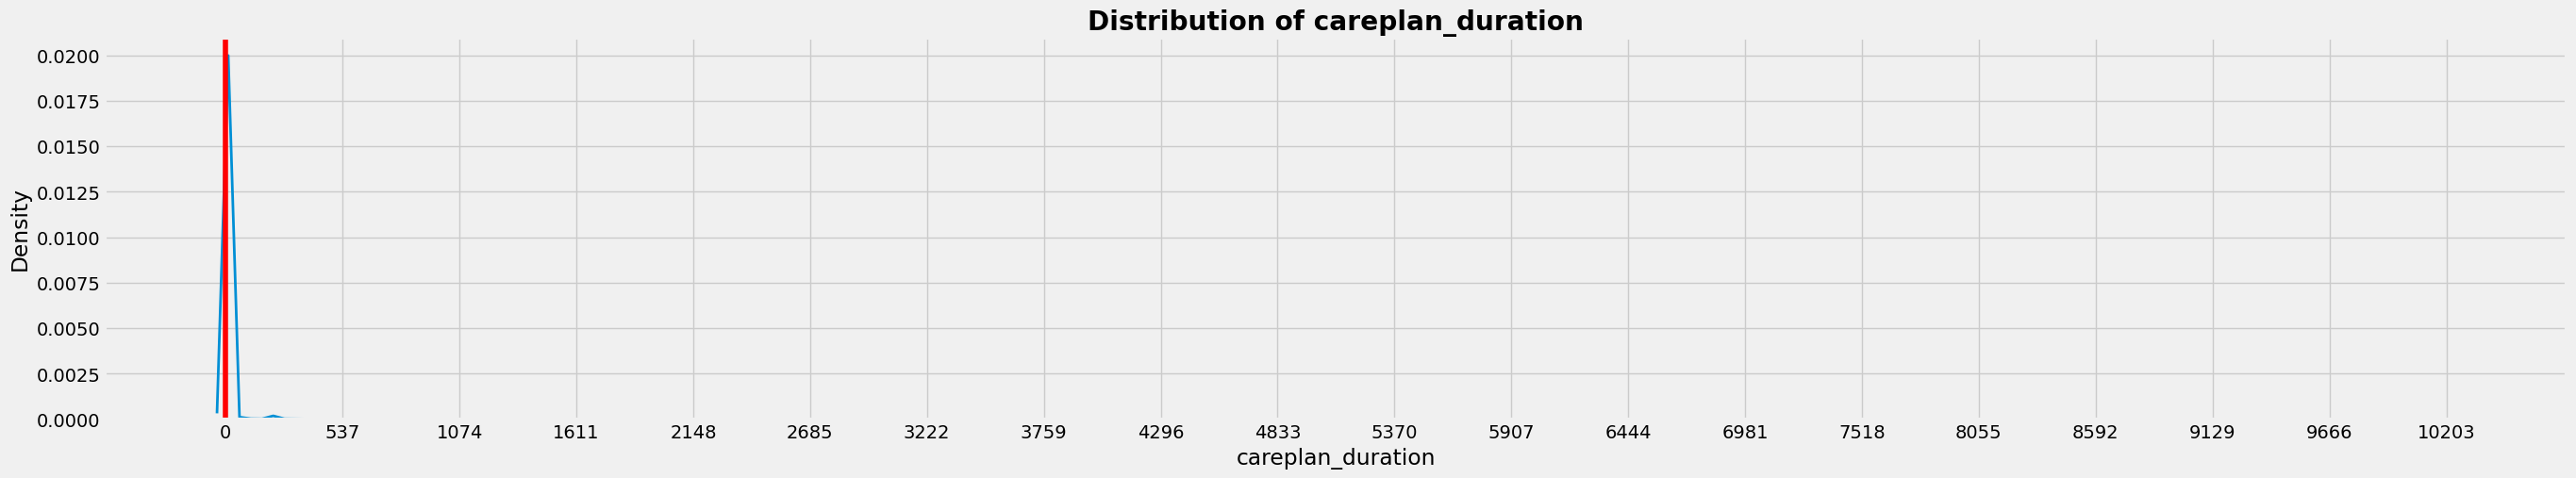

In [75]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'careplan_duration',data= data,line_val=.50)
plt.show()

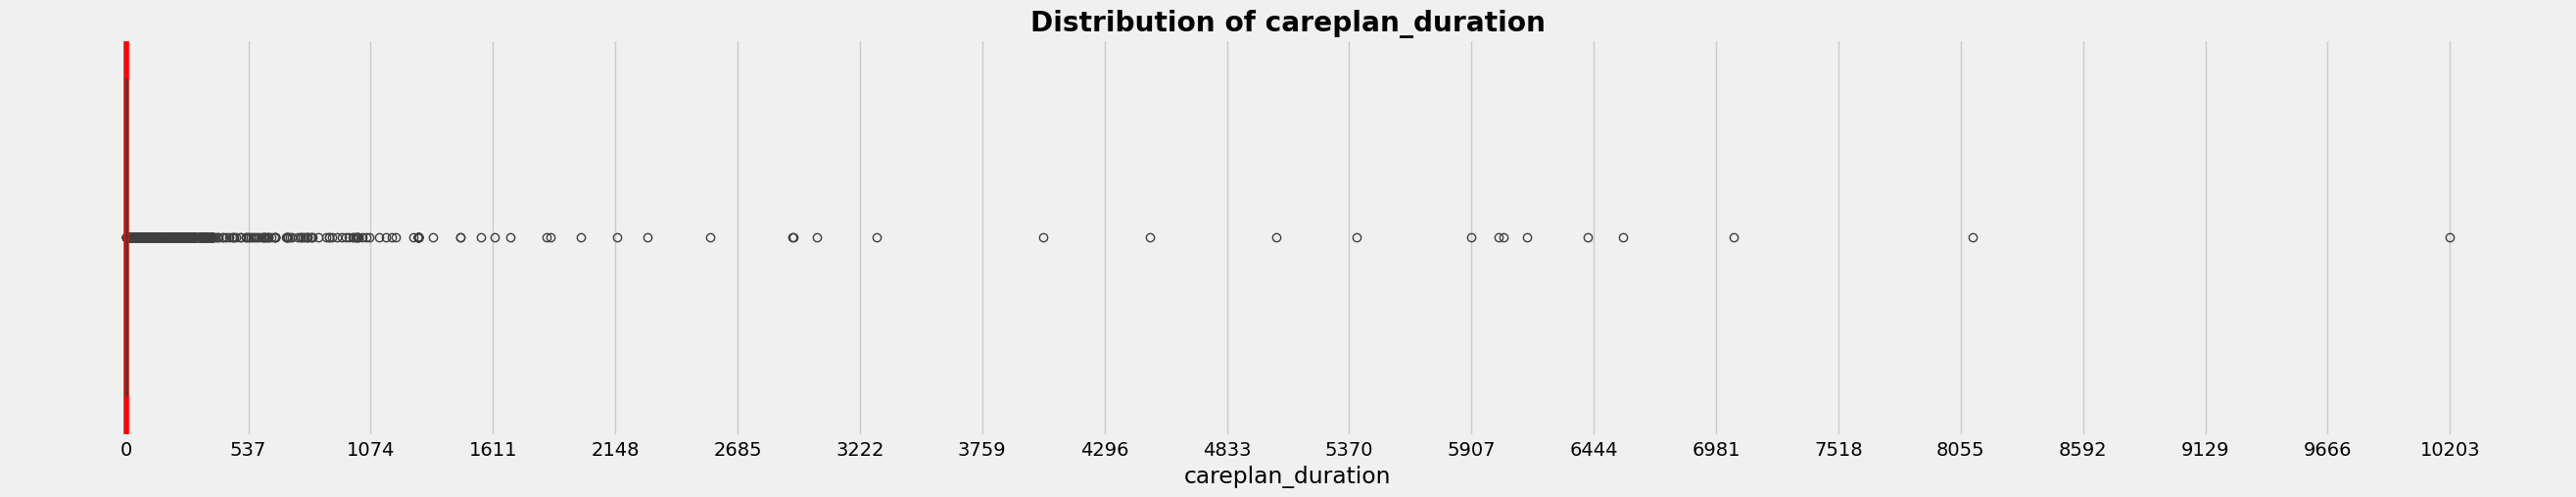

In [76]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'careplan_duration',data= data,line_val=.50)
plt.show()

- **many outliers too**

In [77]:
data.select_dtypes(include='number').nunique().reset_index(name = 'total_unique_values')

index  total_unique_values
0           payer_coverage                   15
1       avg_procedure_cost                15909
2   avg_base_medicine_cost                11010
3  avg_total_medicine_cost                11986
4              age_as_2022                  108
5              utilization                  220
6       caused_readmission                    2
7       condition_duration                  222
8        careplan_duration                  357

In [78]:
data.select_dtypes(include='object').nunique().reset_index(name = 'total_unique_values')

index  total_unique_values
0           encounter_start                50029
1            encounterclass                    6
2       base_encounter_cost                    2
3                  duration                    4
4          total_procedures                    7
5           total_medicines                    7
6   reasons_for_medications                    4
7      is_ongoing_condition                    3
8          total_conditions                    3
9       is_ongoing_careplan                    3
10          total_careplans                    3
11                  marital                    3
12                     race                    5
13                ethnicity                    2
14           patient_gender                    2
15          provider_gender                    2

In [79]:
data.select_dtypes(include='number').nunique().reset_index(name = 'total_unique_values')['index'].values.tolist()

['payer_coverage',
 'avg_procedure_cost',
 'avg_base_medicine_cost',
 'avg_total_medicine_cost',
 'age_as_2022',
 'utilization',
 'caused_readmission',
 'condition_duration',
 'careplan_duration']

In [80]:
cat_cols = ['encounterclass','base_encounter_cost','duration','total_procedures','total_medicines','reasons_for_medications','is_ongoing_condition',
 'total_conditions','is_ongoing_careplan','total_careplans','marital','race','ethnicity','patient_gender','provider_gender']

In [81]:
num_cols = ['payer_coverage','avg_procedure_cost','avg_base_medicine_cost','avg_total_medicine_cost','age_as_2022',
 'utilization','condition_duration','careplan_duration']

In [82]:
target_col = ['caused_readmission']

***

## **Bivariate Analysis with `caused_readmission` column**

### **Categorical Columns with Target**

**encounterclass**

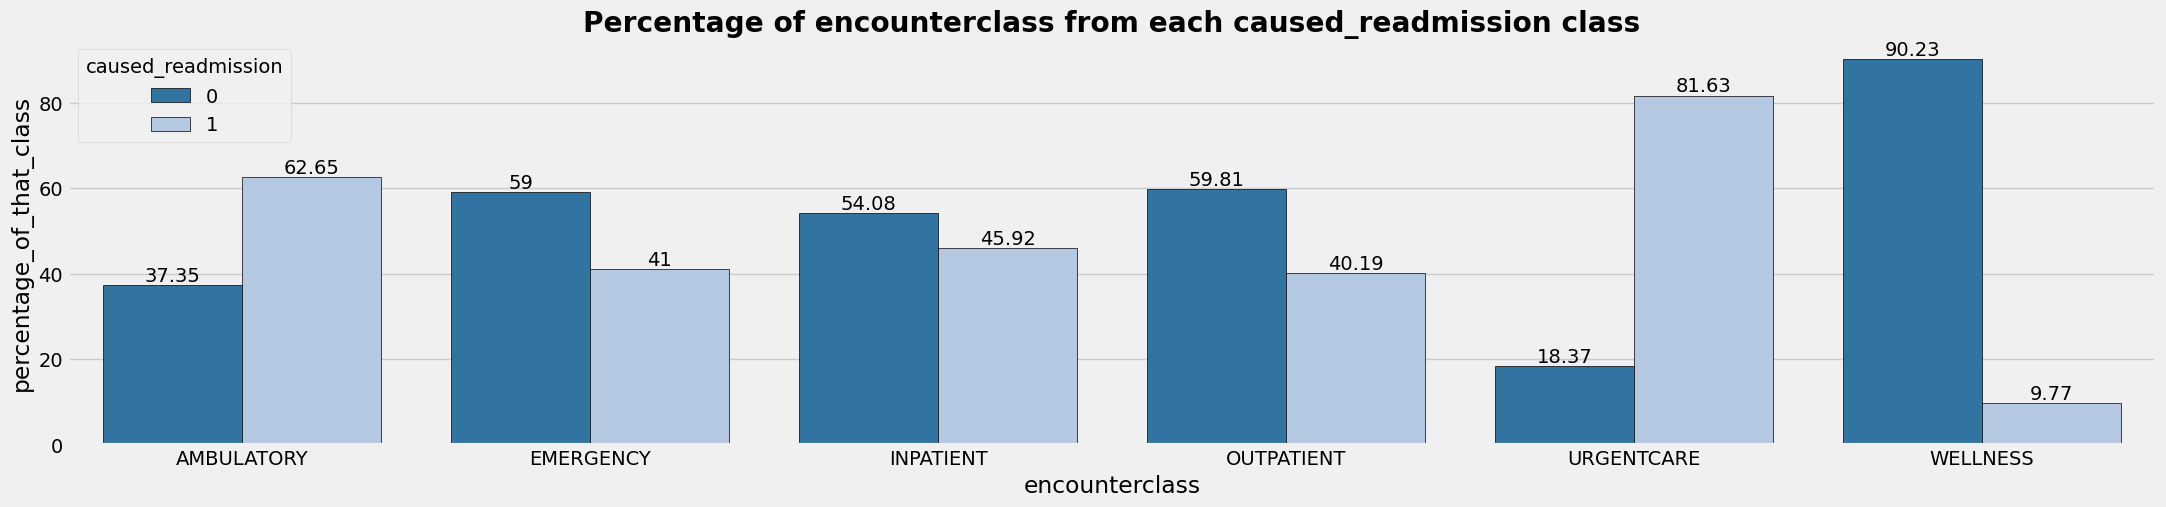

In [83]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='encounterclass',data=data,target='caused_readmission',orient='v')

In [84]:
urgent_care_mask = (data['encounterclass']=='URGENTCARE') | (data['encounterclass']=='AMBULATORY')
ct = pd.crosstab(urgent_care_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.424 → Strong


***
- ***according to the visuals, `ambulatory and urgentcare encounters showed the most observations for caused readmission`, after doing statistical test we can validate a `strong relationship` between `encounterclass` and `causing readmission`***
***

**duration**

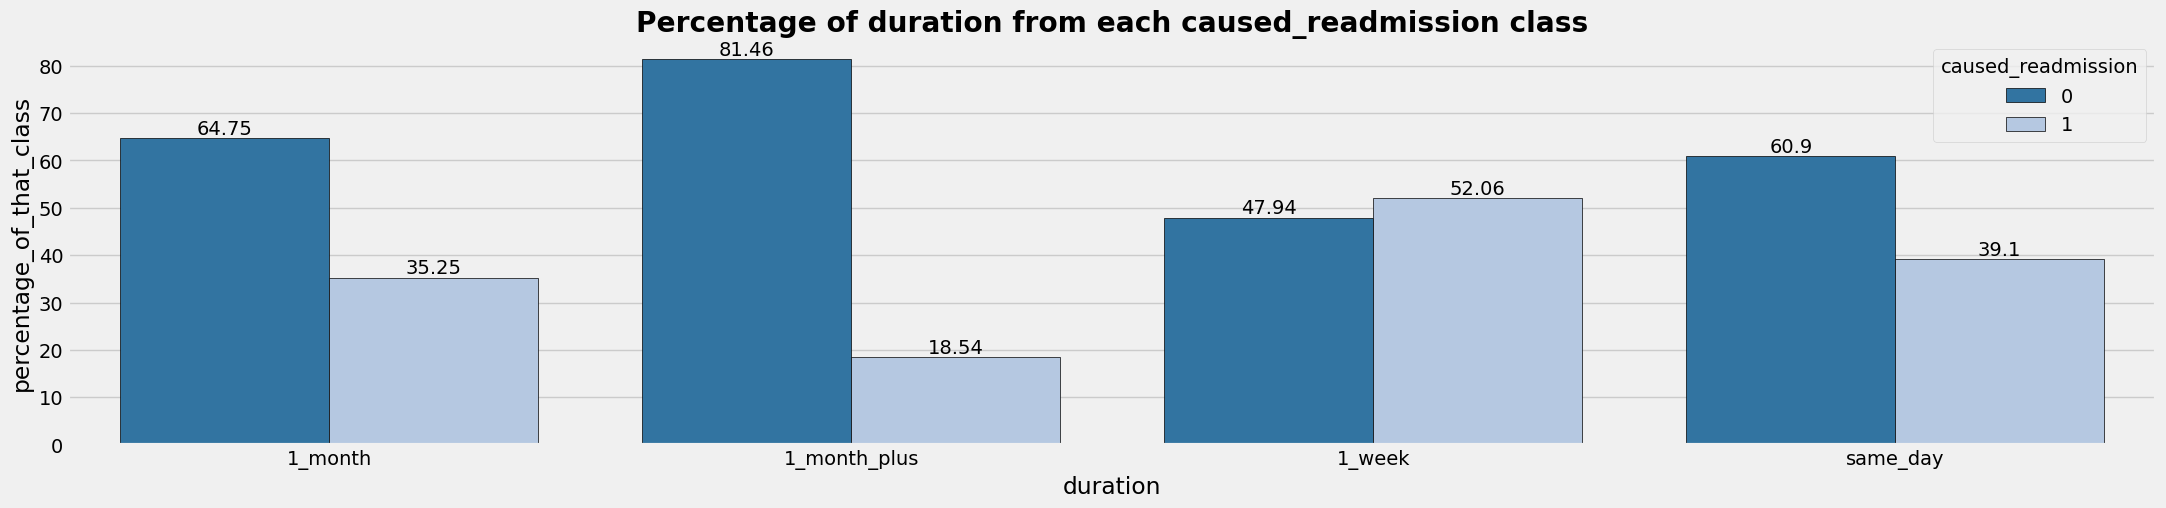

In [85]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='duration',data=data,target='caused_readmission',orient='v')

**Need to do a statistical test to check if there is any association for `1_week` class for causing readmission**

In [86]:
duration_mask = (data['duration']=='1_week')
ct = pd.crosstab(duration_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.041 → Weak


***
***By visuals I saw that `1_week duration is showing high number in causing readmission`, after doing statistical test we can validate a `weak relationship` between `duration of 1_week` and `cause_readmission` column***
***

**marital**

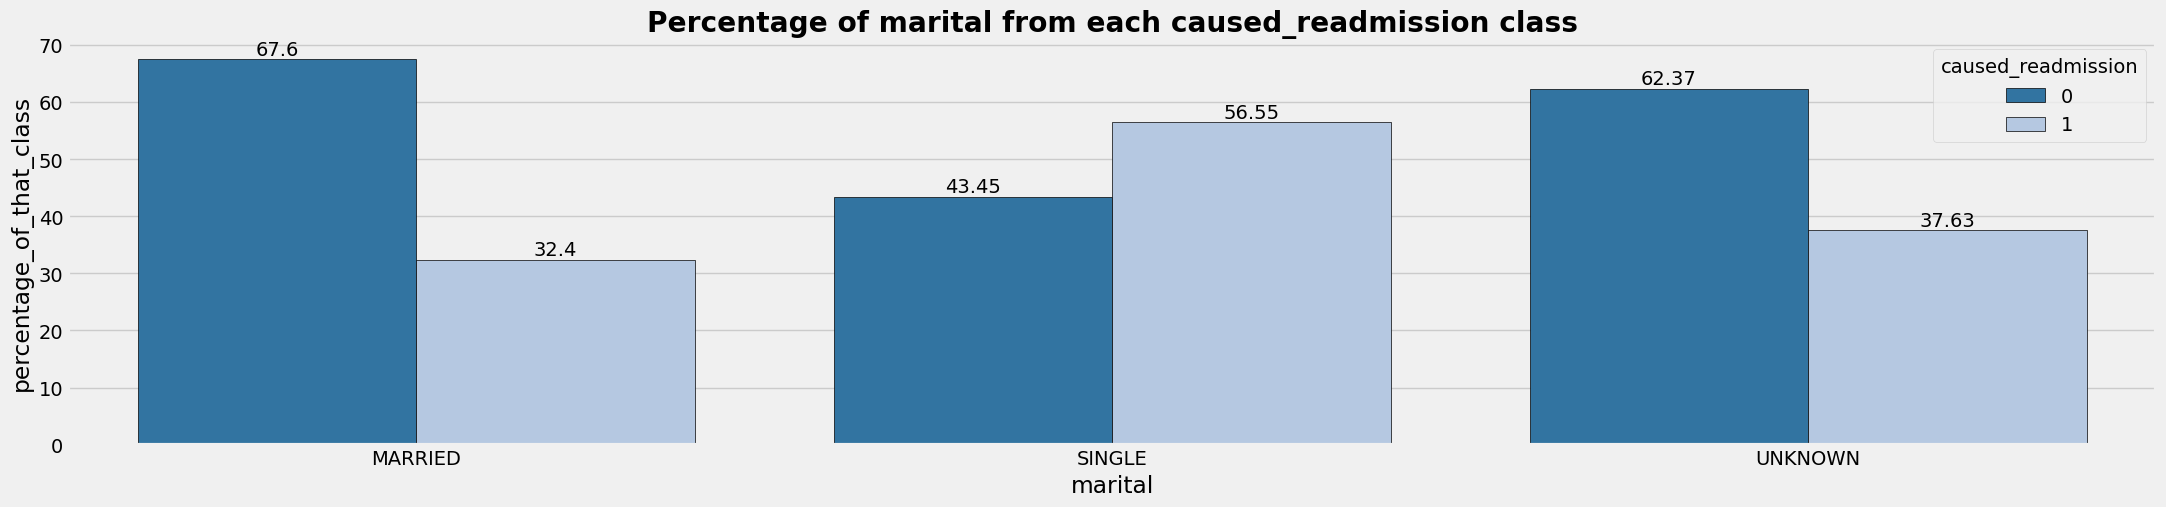

In [87]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='marital',data=data,target='caused_readmission',orient='v')

In [88]:
marital_mask = (data['marital']=='SINGLE')
ct = pd.crosstab(marital_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.202 → Moderate


***
- ***visuals showed that there is a `high percentage of causing readmission in single marital status`, by doing statistical test we can validate that `cause_readmission` column have `moderate relationship` with `marital class single`***
***

**ethnicity**

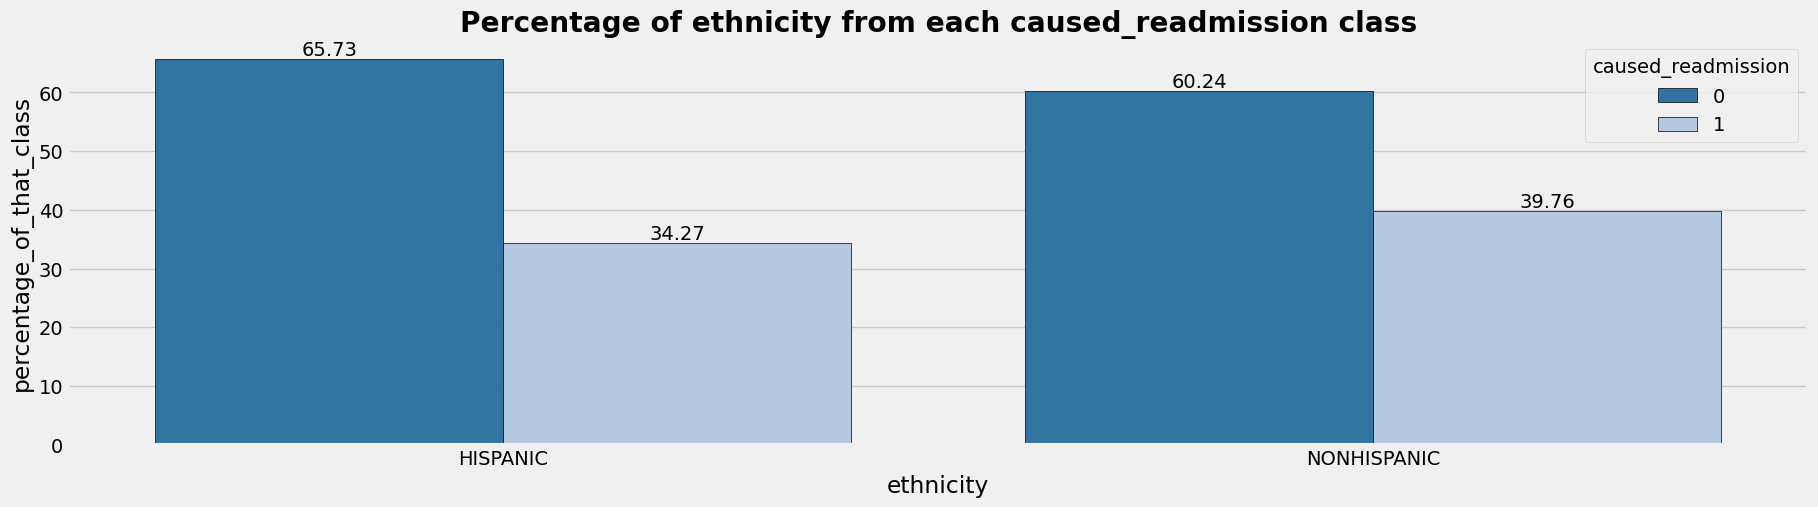

In [89]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='ethnicity',data=data,target='caused_readmission',orient='v')

- **we do not see any strong pattern in between ethnicity and caused readmission**

**race**

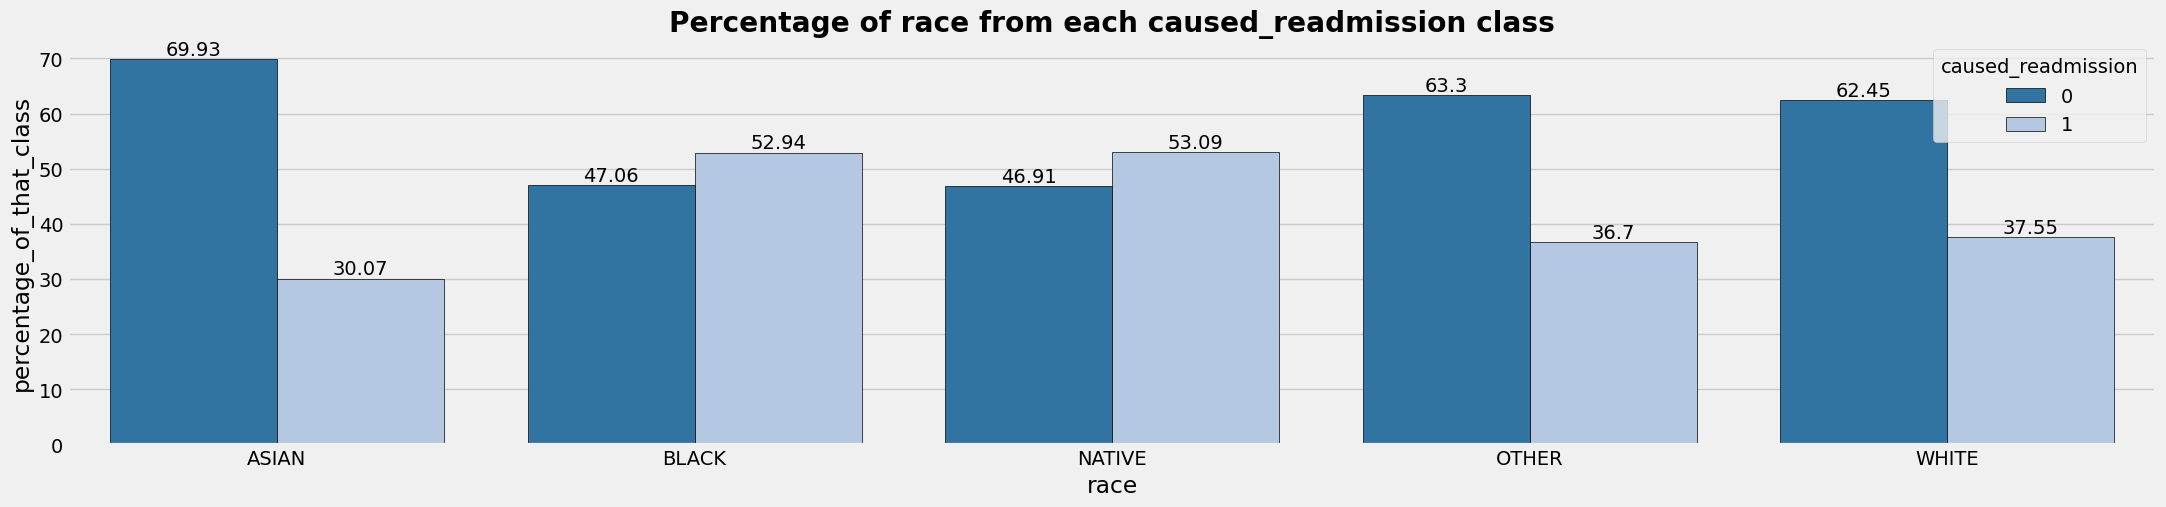

In [90]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='race',data=data,target='caused_readmission',orient='v')

In [91]:
race_mask = (data['race']=='BLACK') |(data['race']=='NATIVE')
ct = pd.crosstab(race_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.116 → Moderate


***
- ***by visuals we saw that `black and native race is showing high percentage of values in cause readmission class`, after doing statistical test we can validate that `cause_readmission` column have a `moderate relationship` with `black` and `native` race***
***

**patient_gender**

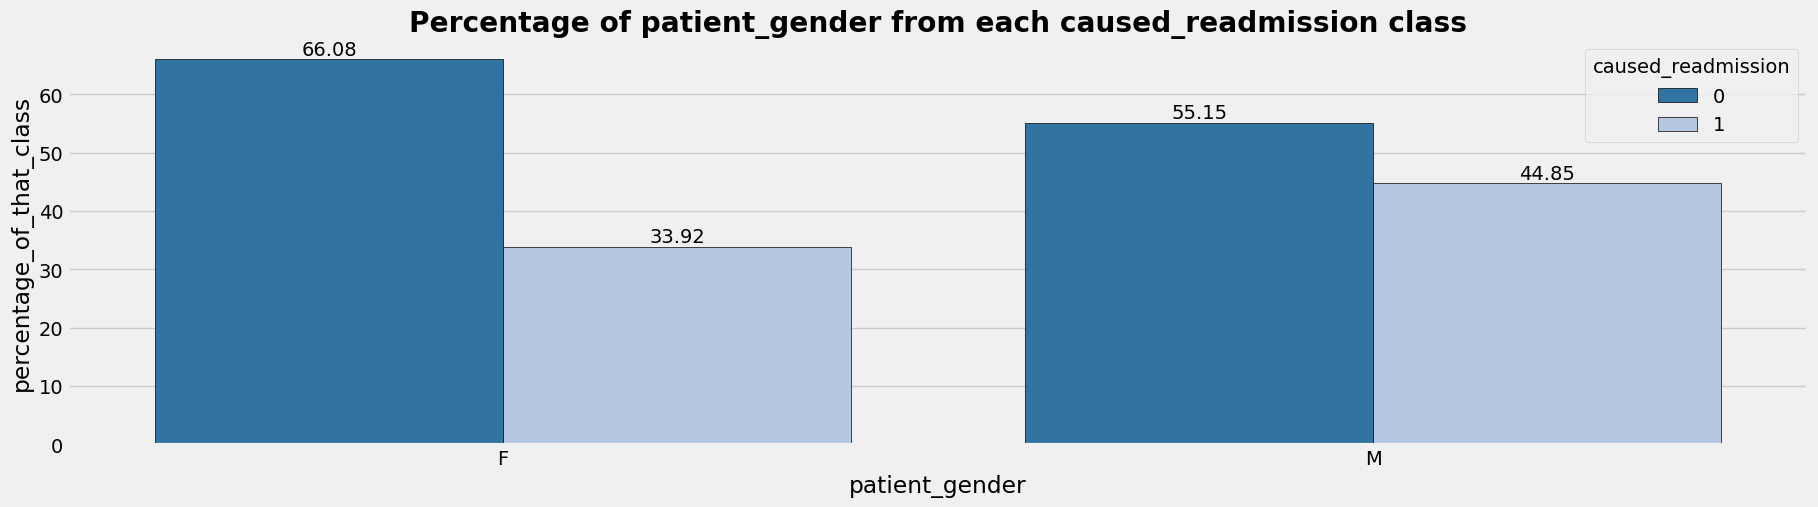

In [92]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='patient_gender',data=data,target='caused_readmission',orient='v')

In [93]:
S.chi_sqared_test(pd.crosstab(data['patient_gender'],data['caused_readmission']))

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.112 → Moderate


***
- ***by visuals we saw that `M patient gender have slightly more values in caused_readmission`, after doing statistical test we can validate this assumption wit `moderate strength`***
***

**provider_gender**

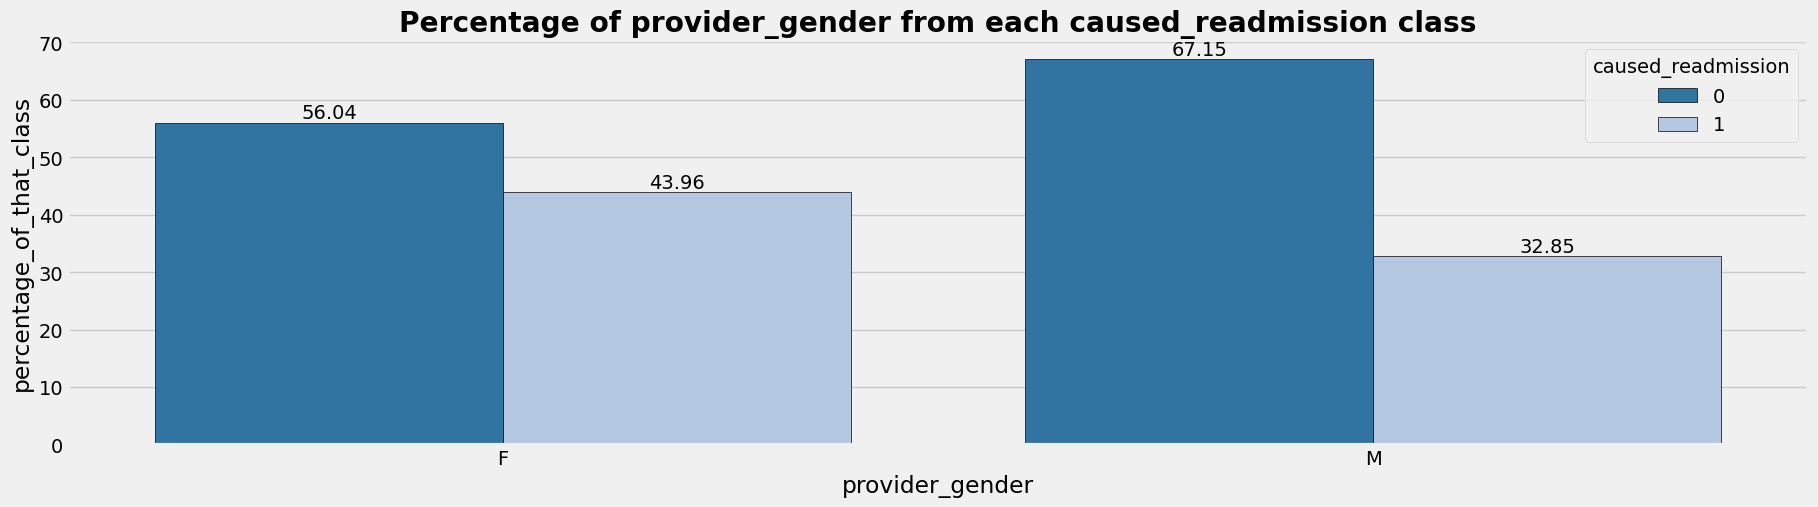

In [94]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='provider_gender',data=data,target='caused_readmission',orient='v')

In [95]:
S.chi_sqared_test(pd.crosstab(data['provider_gender'],data['caused_readmission']))

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.112 → Moderate


***
- ***by visuals we saw that `F provider gender have slightly more values in caused_readmission`, after doing statistical test we can validate this assumption with `moderate strength`***
***

**base_encounter_cost**

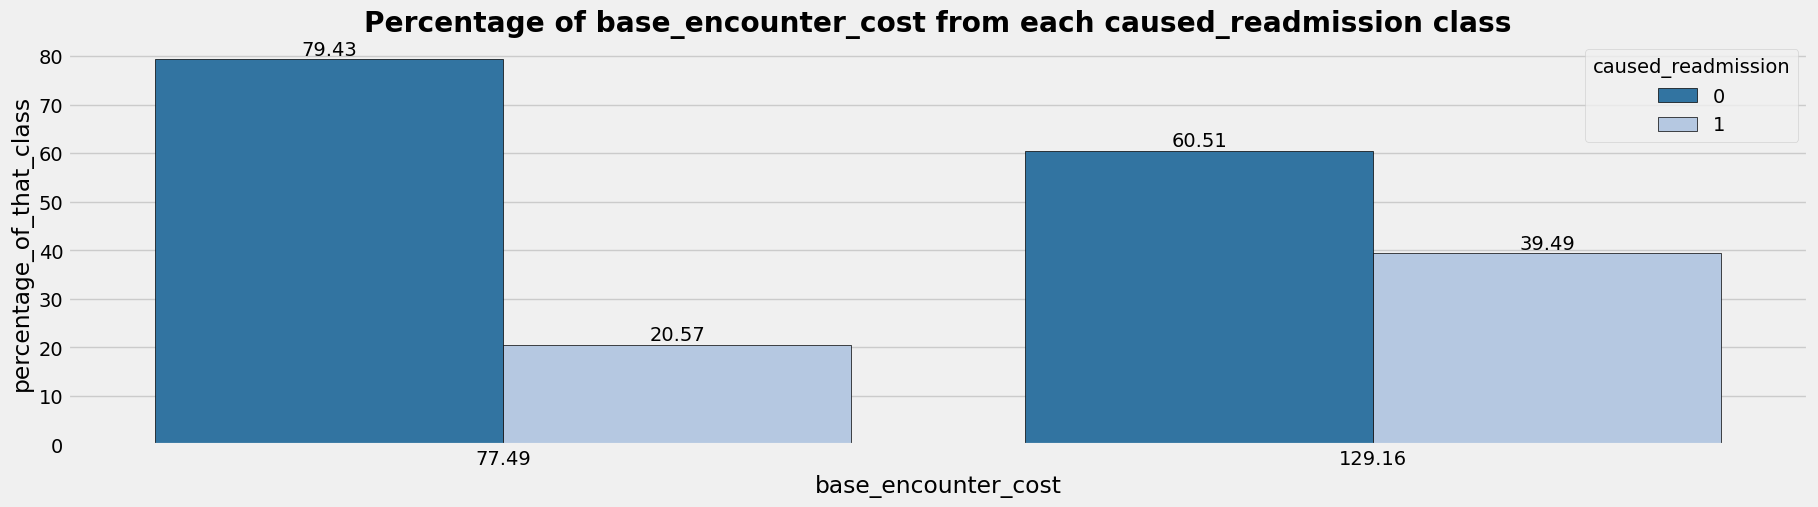

In [96]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='base_encounter_cost',data=data,target='caused_readmission',orient='v')

In [97]:
S.chi_sqared_test(pd.crosstab(data['base_encounter_cost'],data['caused_readmission']))

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.034 → Weak


- **nothing specific found from base encounter cost, have very weak relationship with caused readmission column**

**reason_for_medications**

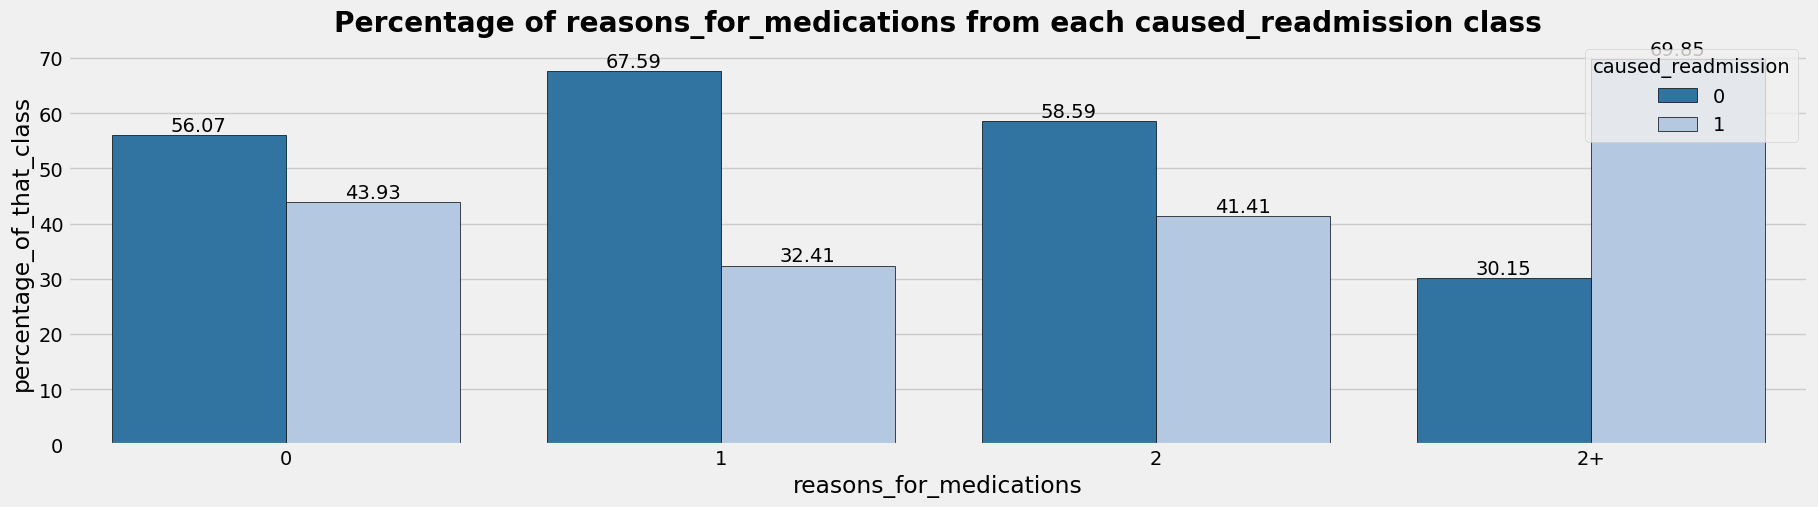

In [98]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='reasons_for_medications',data=data,target='caused_readmission',orient='v')

In [99]:
reason_for_medication_mask = (data['reasons_for_medications']=='2+')
ct = pd.crosstab(reason_for_medication_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.031 → Weak


- **we do not see anything specific**

**is_ongoing_condition**

In [100]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='is_ongoing_condition',data=data,target='caused_readmission',orient='v')

In [101]:
is_ongoing_condition_mask = (data['is_ongoing_condition']=='FINISHED')
ct = pd.crosstab(is_ongoing_condition_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.053 → Weak


In [102]:
ct = pd.crosstab(data['is_ongoing_condition'],data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.094 → Weak


**we dont see any thing specific, both columns have very weak relationship**

**is_ongoing_careplan**

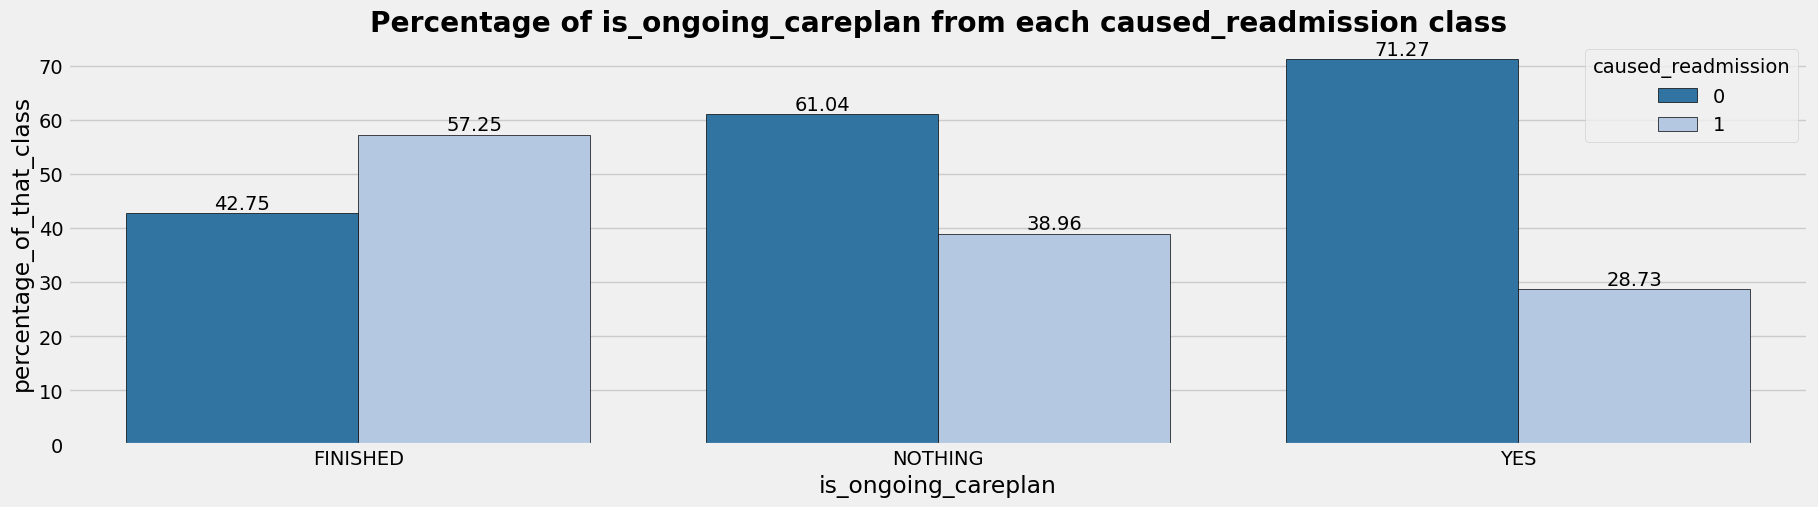

In [103]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='is_ongoing_careplan',data=data,target='caused_readmission',orient='v')

In [104]:
ongoing_careplan_mask = (data['is_ongoing_careplan']=='FINISHED')
ct = pd.crosstab(ongoing_careplan_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.071 → Weak


- **ongoing careplan have weak relationship with the caused readmission column**

**total_careplans**

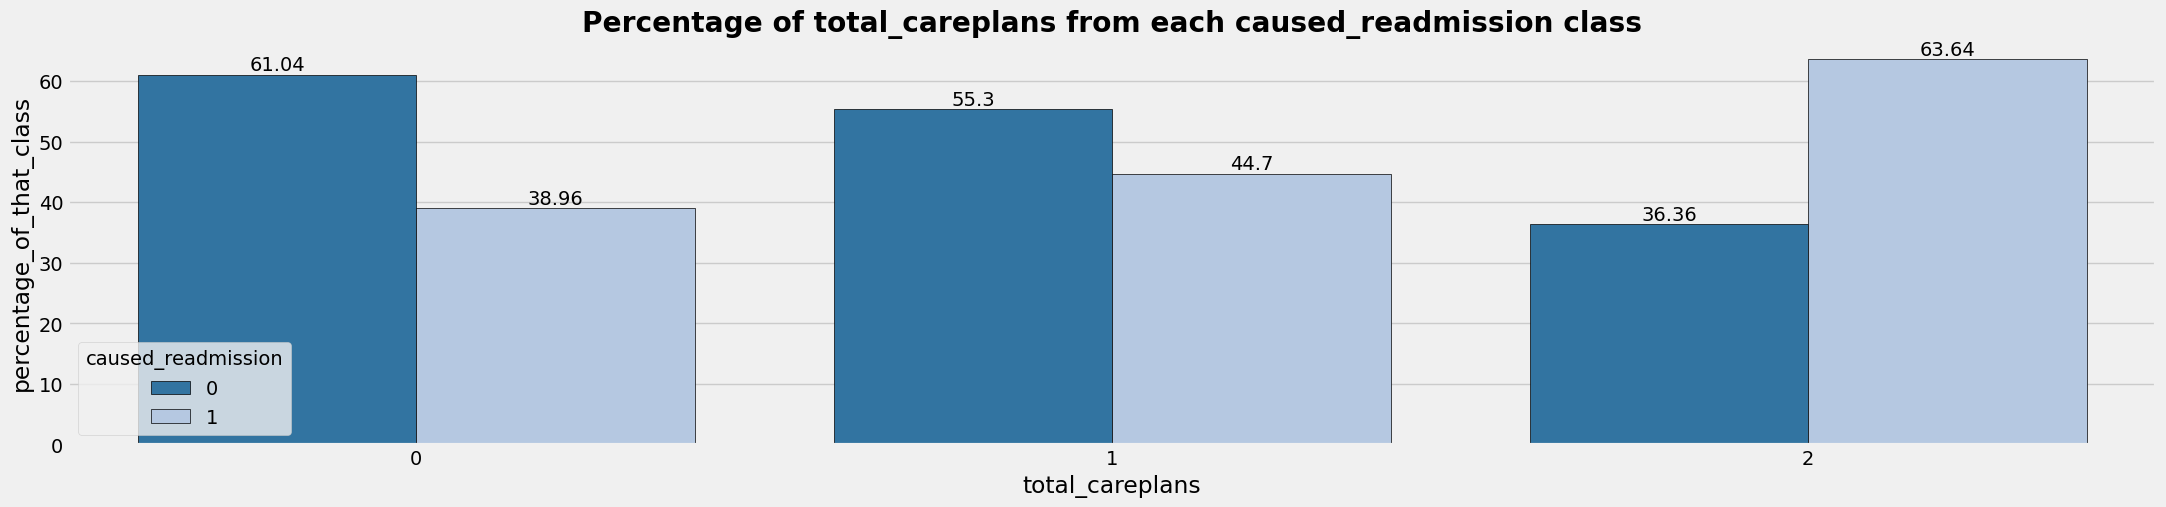

In [105]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='total_careplans',data=data,target='caused_readmission',orient='v')

In [106]:
total_careplan_mask = (data['total_careplans']==2)
ct = pd.crosstab(total_careplan_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.17983
Fail to reject null (groups similar)
Cramer's V: 0.006 → Weak


- **there is very weak associatation**

***

**total_procedures**

In [107]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='total_procedures',data=data,target='caused_readmission',orient='v')

In [108]:
ct = pd.crosstab(data['total_procedures'],data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.335 → Strong


***
- ***visuals showed that `more the procedures, the more the causing of readmission`, after doing statistical test we can validate this assumption with `strong strength`***
***

**total_conditions**

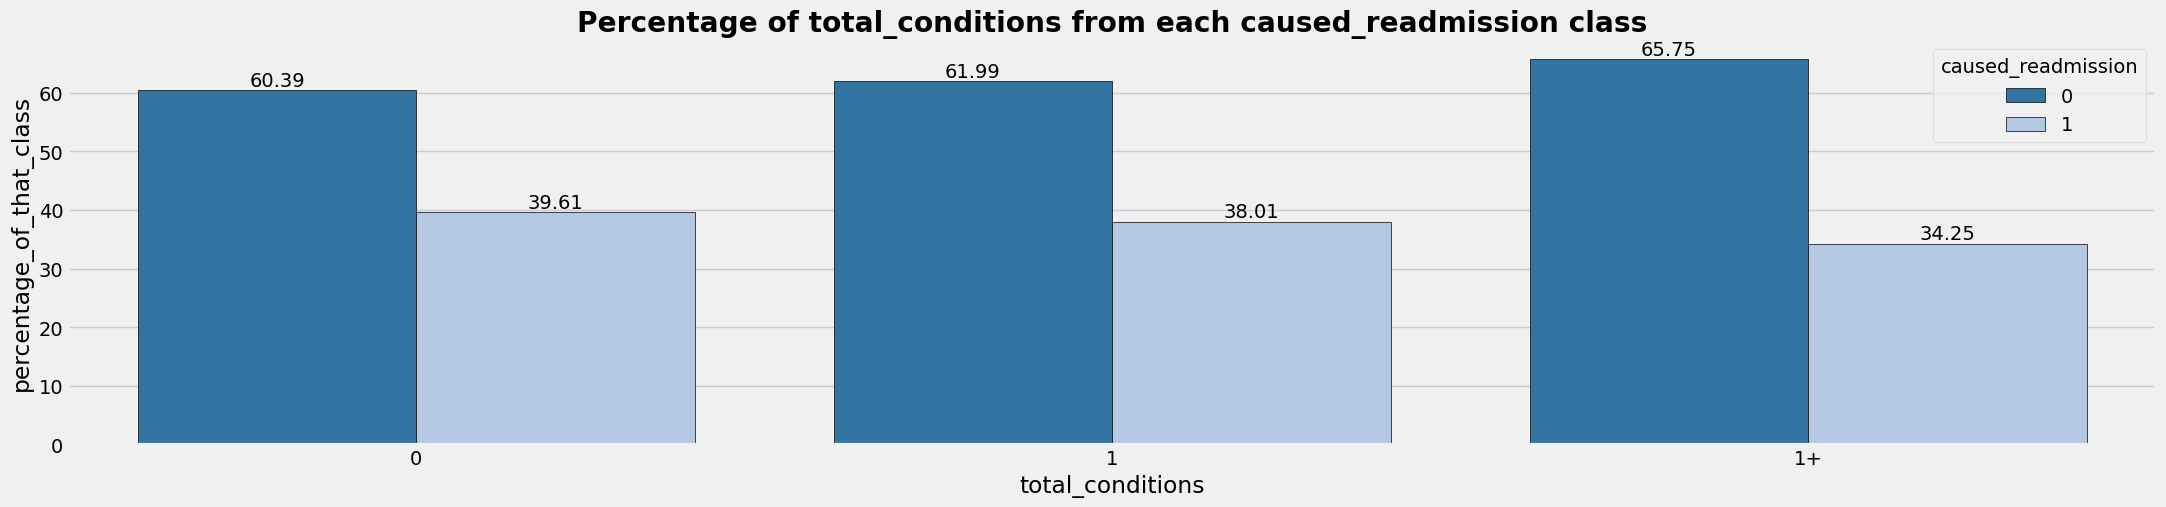

In [109]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='total_conditions',data=data,target='caused_readmission',orient='v')

- **we do not see anything specific**

**total_medicines**

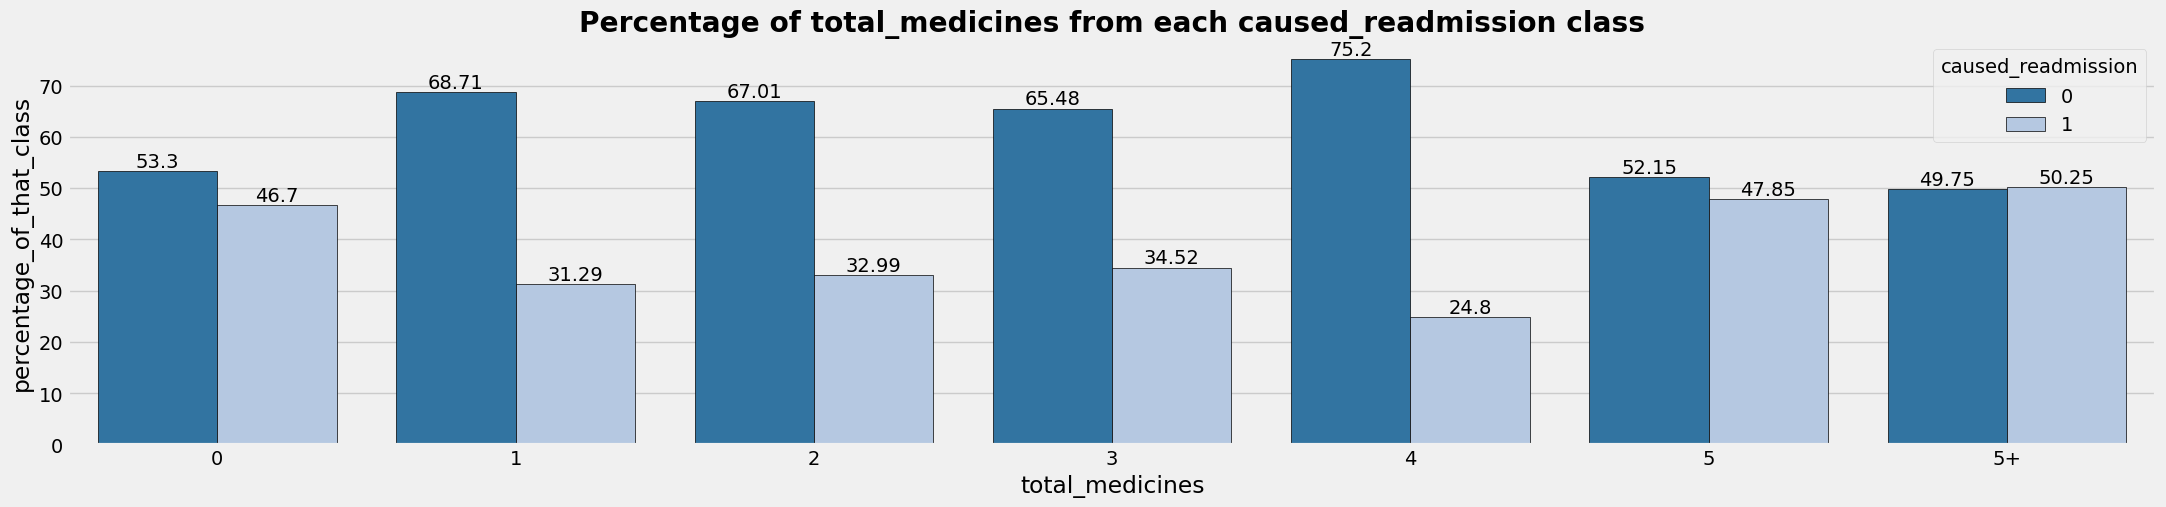

In [110]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='total_medicines',data=data,target='caused_readmission',orient='v')

In [111]:
total_medicine_mask = (data['total_medicines']=='5') | (data['total_medicines']=='5+') | (data['total_medicines']=='0')
ct = pd.crosstab(total_medicine_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.155 → Moderate


***
- ***visuals showed that` when no medicine was provider or 5 or more than 5 medicines were provided, then there were more values in cause readmission`, after doing statistical test we can validate this assumption with `moderate strength`***
***

### ***Numerical Columns with target***

**avg_procedure_cost**

In [112]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='avg_procedure_cost',data= data,target='caused_readmission')

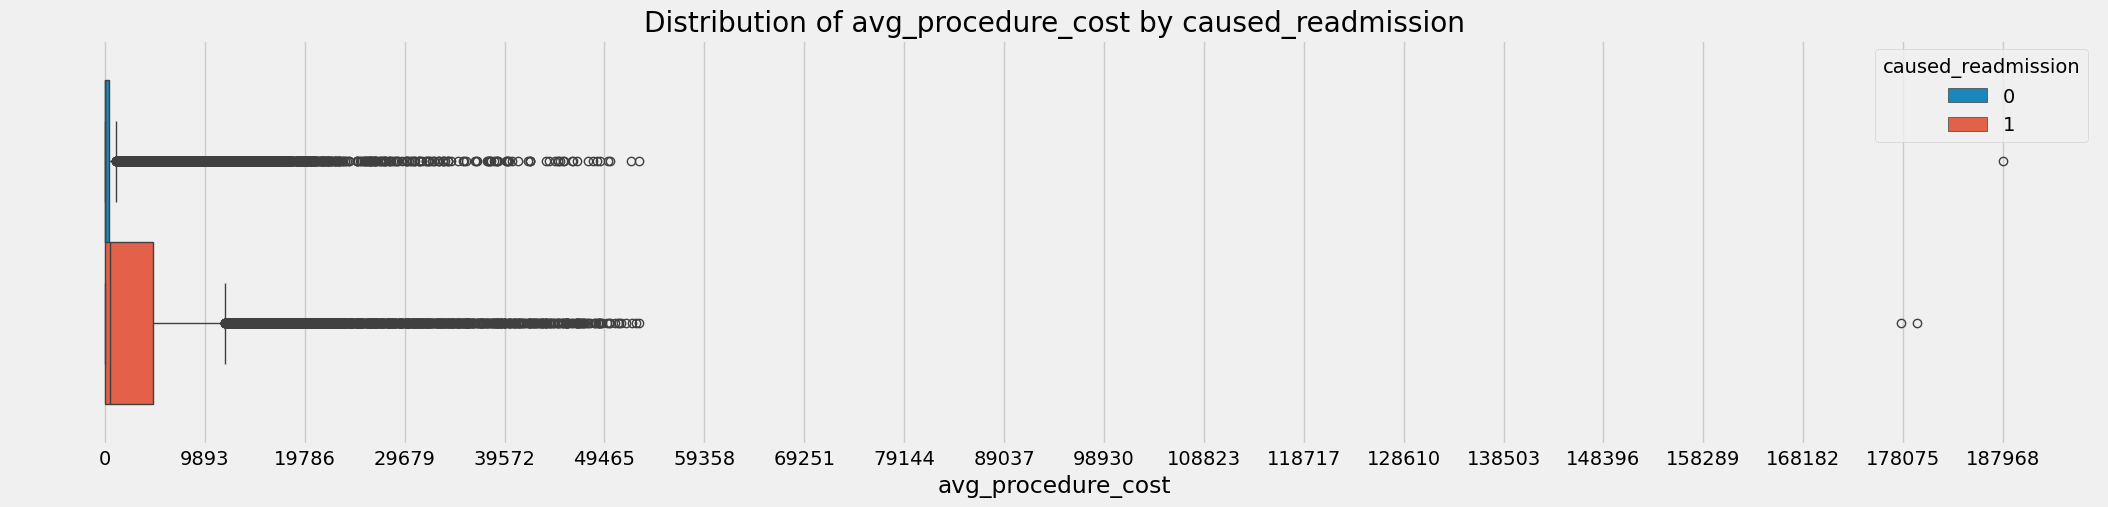

In [113]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='avg_procedure_cost',data= data,target='caused_readmission')

In [114]:
data.groupby('caused_readmission')['avg_procedure_cost'].describe().round(2).T

caused_readmission          0          1
count                32361.00   20985.00
mean                  1078.99    3749.38
std                   3760.78    7312.78
min                      0.00       0.00
25%                      0.00       0.00
50%                      0.00     516.65
75%                    446.31    4758.14
max                 187968.69  179470.09

In [115]:
S.numerical_test(data,'caused_readmission','avg_procedure_cost',1)

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: weak


- **we do not find anything specific**

**avg_base_medicine_cost**

In [116]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='avg_base_medicine_cost',data= data,target='caused_readmission')

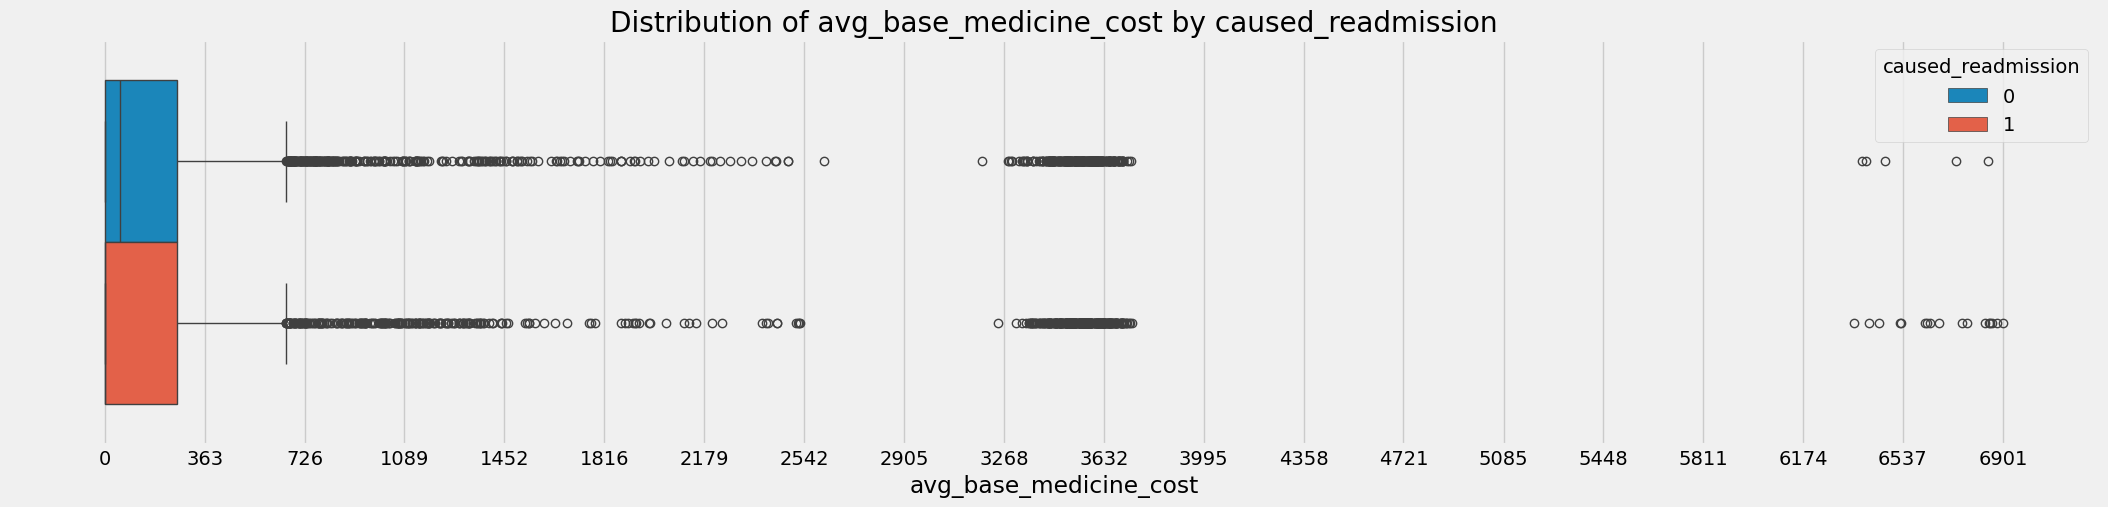

In [117]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='avg_base_medicine_cost',data= data,target='caused_readmission')

In [118]:
data.groupby('caused_readmission')['avg_base_medicine_cost'].describe().round(2).T

caused_readmission         0         1
count               32361.00  20985.00
mean                  164.64    159.46
std                   353.47    477.39
min                     0.00      0.00
25%                     0.00      0.00
50%                    56.09      0.00
75%                   263.49    263.49
max                  6845.44   6901.17

In [119]:
S.numerical_test(data,'caused_readmission','avg_base_medicine_cost',1)

Data has normal distribution so doing ttest_ind ->
Data has equal variance
T-test p-value: 0.15052 → Fail to reject null (groups similar)
Strength of ttest: very weak


- **we do not see any specific pattern, relationship is also very weak**

**avg_total_medicine_cost**

In [120]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='avg_total_medicine_cost',data= data,target='caused_readmission')

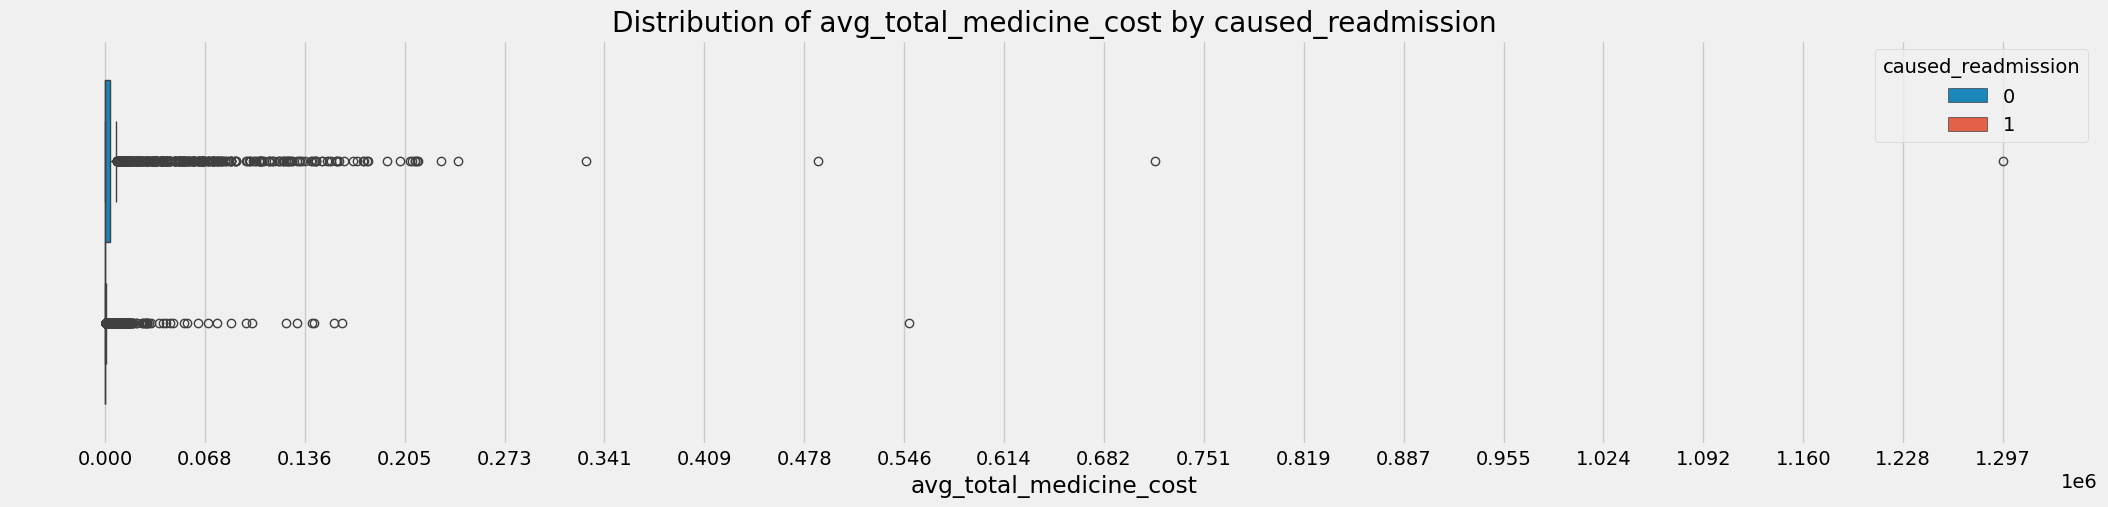

In [121]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='avg_total_medicine_cost',data= data,target='caused_readmission')

In [122]:
data.groupby('caused_readmission')['avg_total_medicine_cost'].describe().round(2).T

caused_readmission           0          1
count                 32361.00   20985.00
mean                   2021.88     521.54
std                   12063.98    4996.15
min                       0.00       0.00
25%                       0.00       0.00
50%                     294.89       0.00
75%                    3161.88     263.49
max                 1296594.95  549067.89

In [123]:
S.numerical_test(data,'caused_readmission','avg_total_medicine_cost',1)

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: very weak


**we dont see anything specific and the relationship is also very weak**

**age_as_2022**

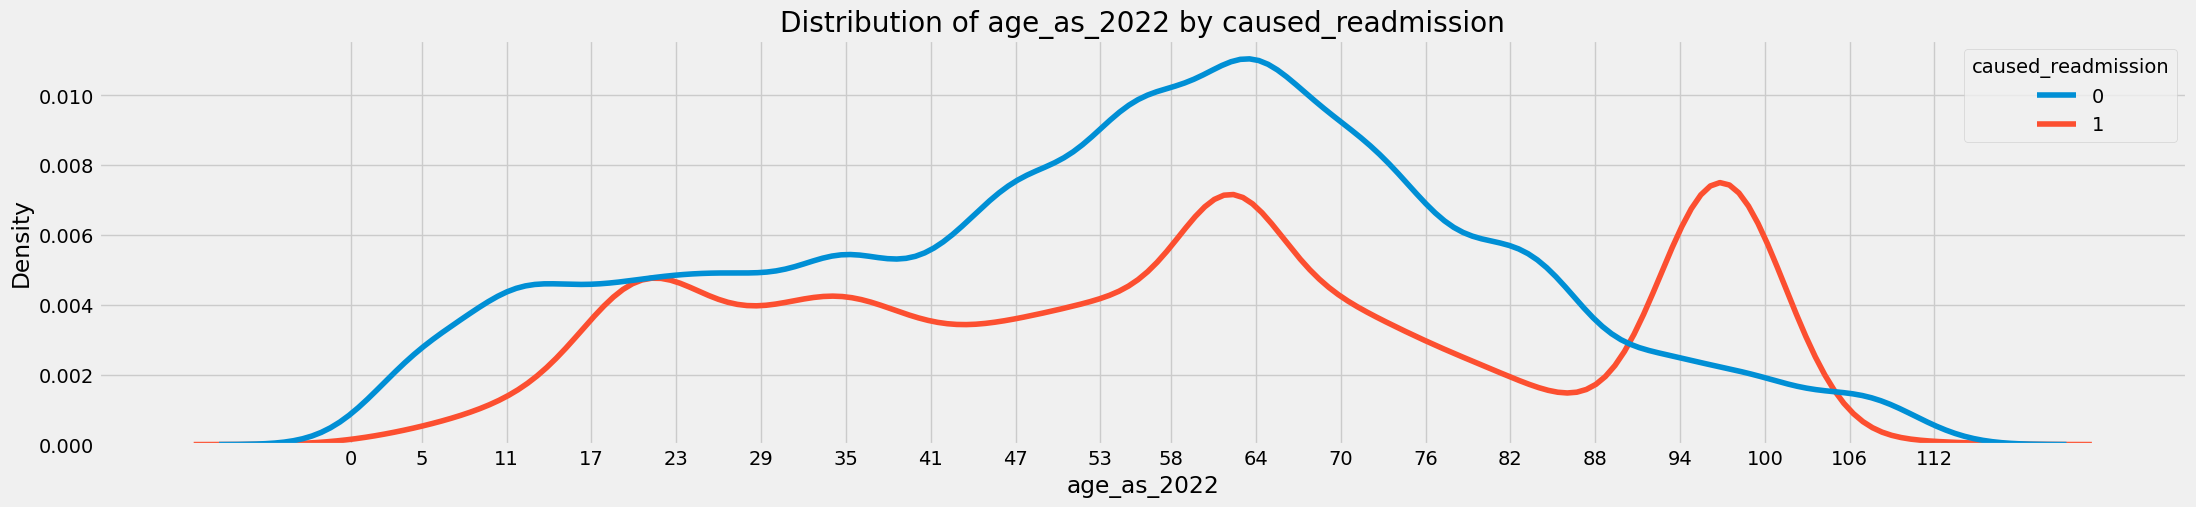

In [124]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='age_as_2022',data= data,target='caused_readmission')

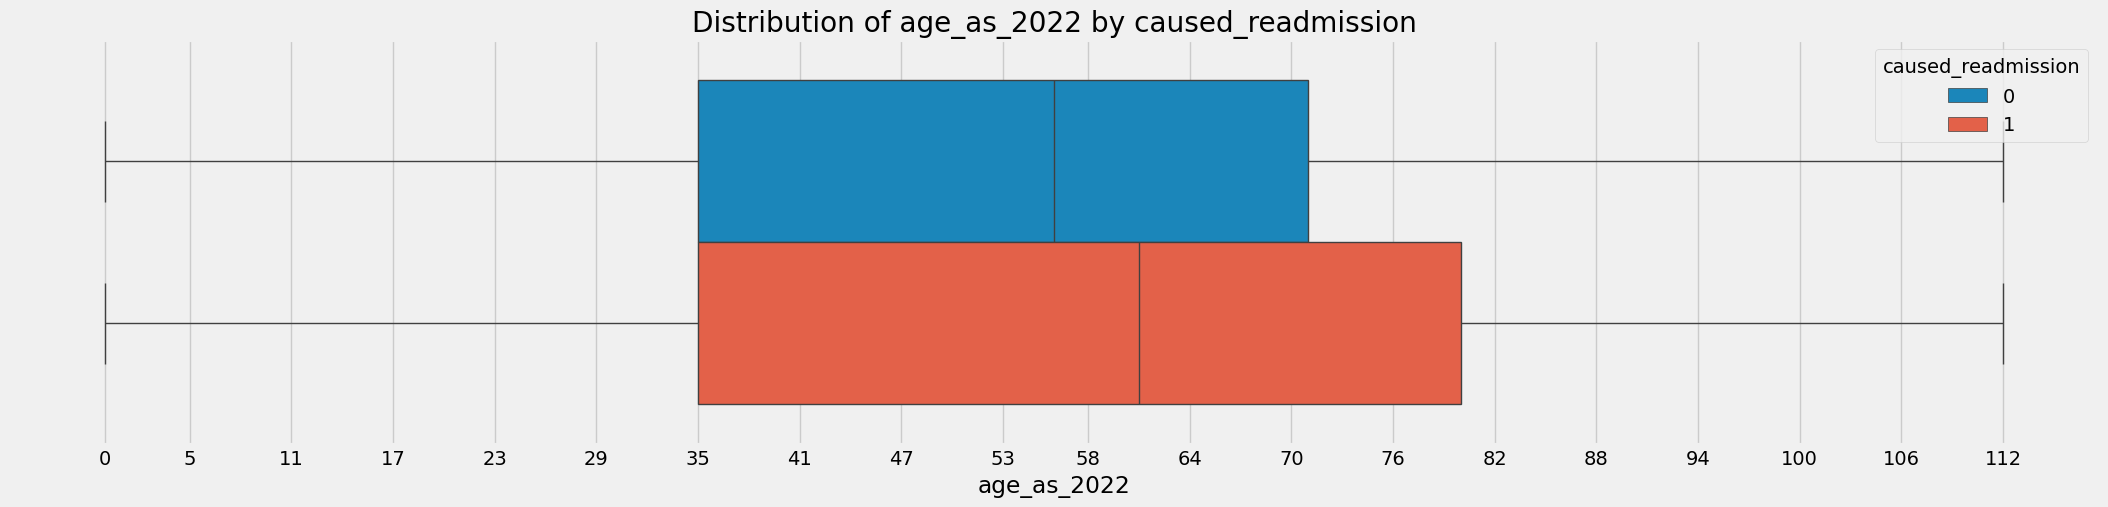

In [125]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='age_as_2022',data= data,target='caused_readmission')

In [126]:
data.groupby('caused_readmission')['age_as_2022'].describe().round(2).T

caused_readmission         0         1
count               32361.00  20985.00
mean                   53.89     58.38
std                    24.84     27.16
min                     0.00      0.00
25%                    35.00     35.00
50%                    56.00     61.00
75%                    71.00     80.00
max                   112.00    112.00

In [127]:
S.numerical_test(data,'caused_readmission','age_as_2022',1)

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: very weak


- **we saw a difference in mean, but statistical test says a very weak relationship**

**utilization**

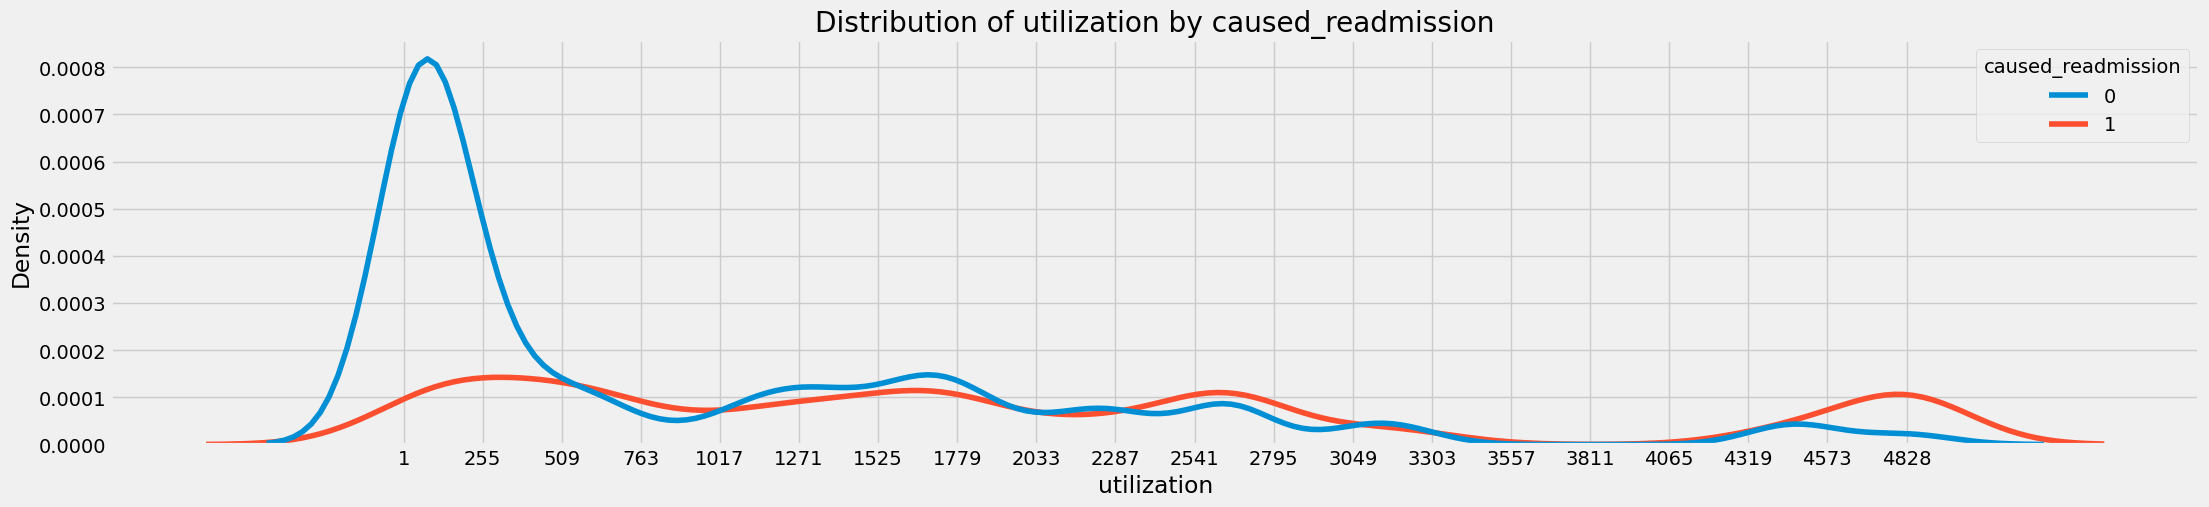

In [128]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='utilization',data= data,target='caused_readmission')

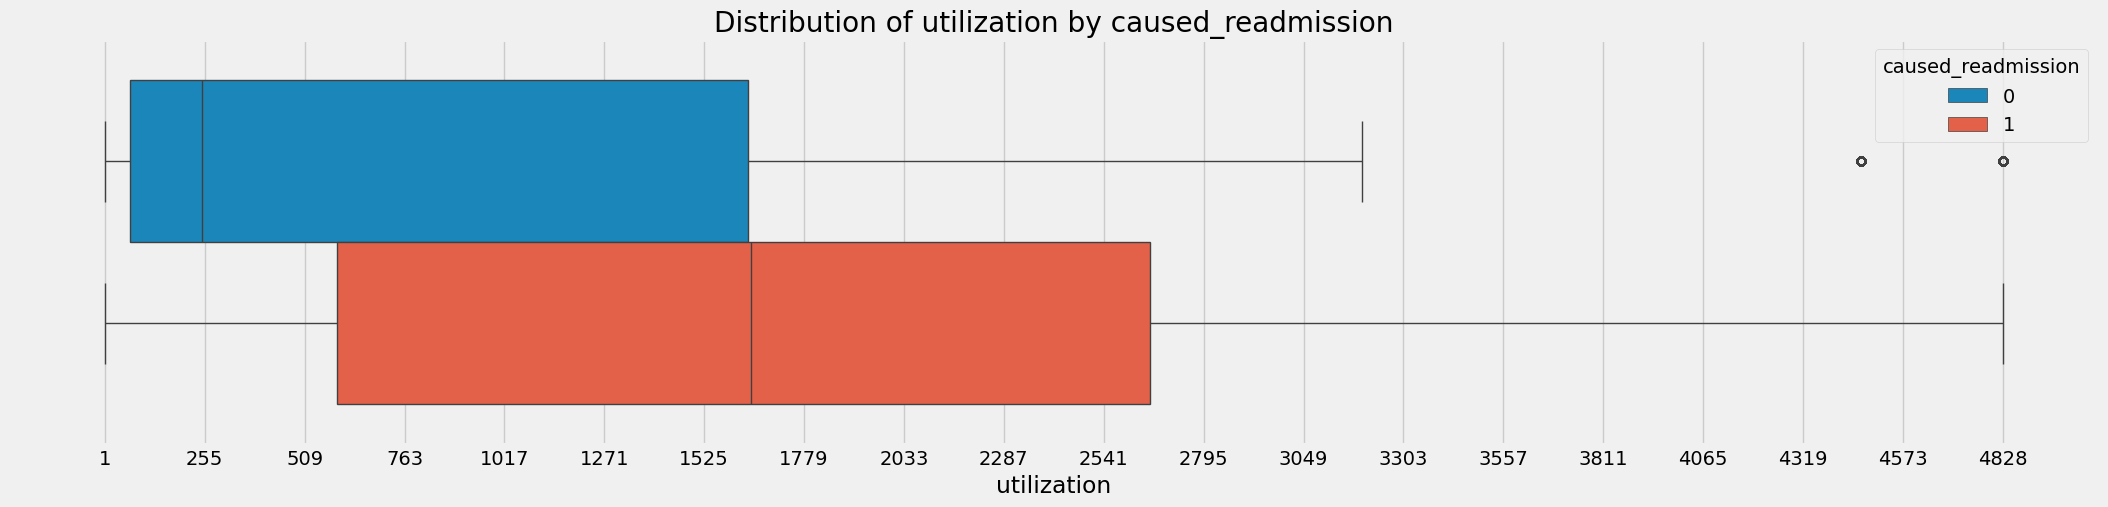

In [129]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='utilization',data= data,target='caused_readmission')

In [130]:
data.groupby('caused_readmission')['utilization'].describe().round(2).T

caused_readmission         0         1
count               32361.00  20985.00
mean                  917.01   1966.10
std                  1172.65   1547.18
min                     2.00      1.00
25%                    64.00    590.00
50%                   248.00   1643.00
75%                  1636.00   2658.00
max                  4828.00   4828.00

In [131]:
S.numerical_test(data,'caused_readmission','utilization',1)

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: medium


***
- ***visuals showed that `utilization value in higher end is more into caused readmission`, after doing statistical test we can validate this relationship with `medium strength`***
***

**condition_duration**

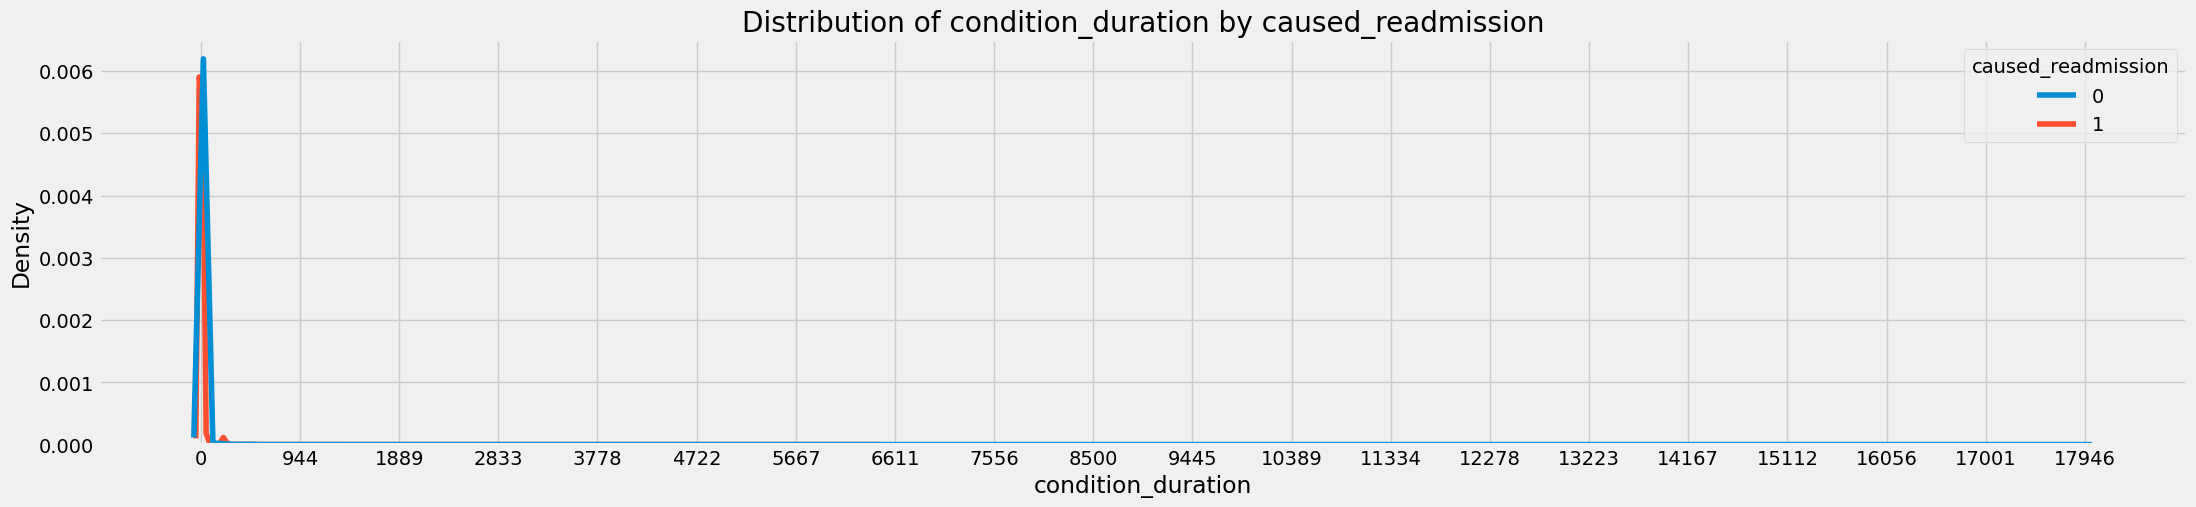

In [132]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='condition_duration',data= data,target='caused_readmission')

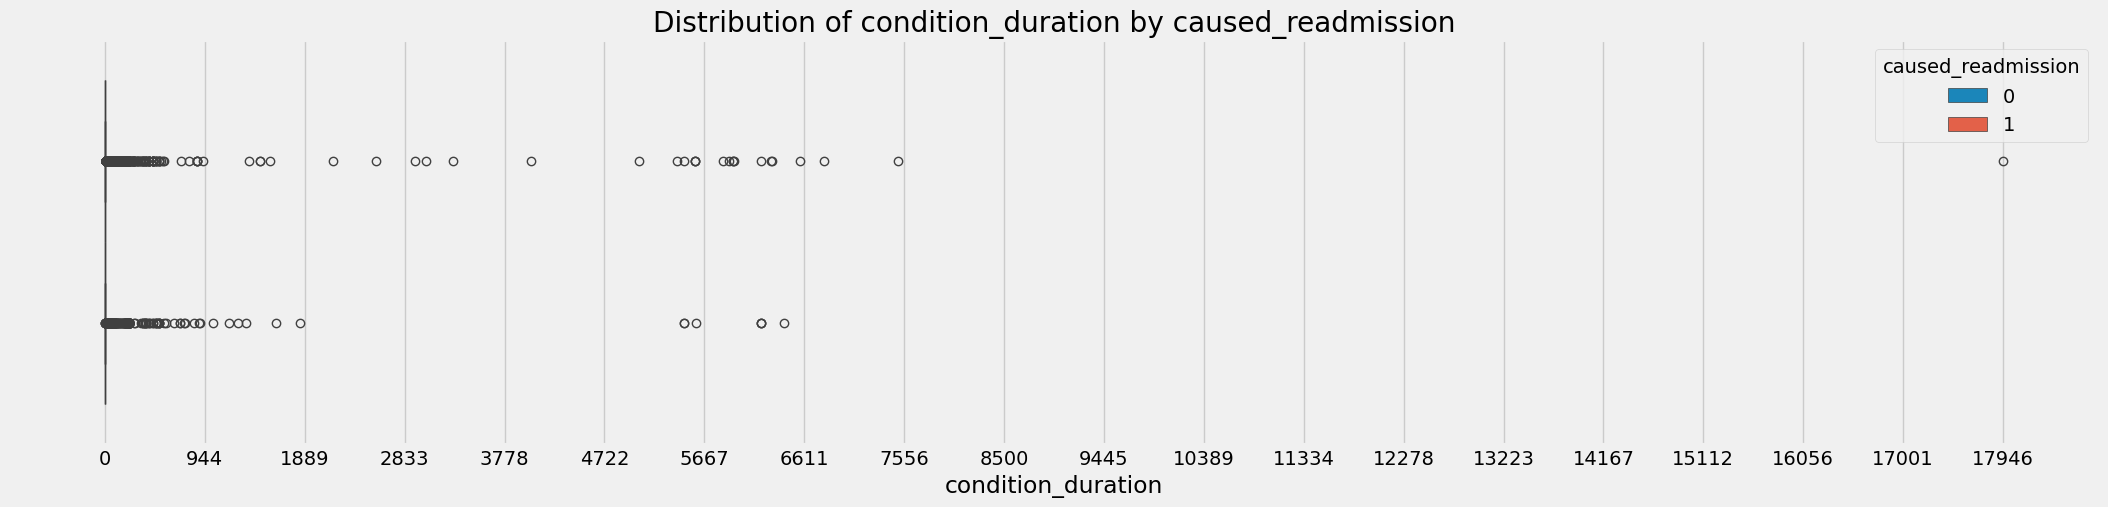

In [133]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='condition_duration',data= data,target='caused_readmission')

In [134]:
data.groupby('caused_readmission')['condition_duration'].describe().round(2).T

caused_readmission        0        1
count               32361.0  20985.0
mean                   7.28     7.74
std                  177.63   116.11
min                     0.0      0.0
25%                     0.0      0.0
50%                     0.0      0.0
75%                     0.0      0.0
max                 17946.0   6418.0

- **nothing specific found**

**careplan_duration**

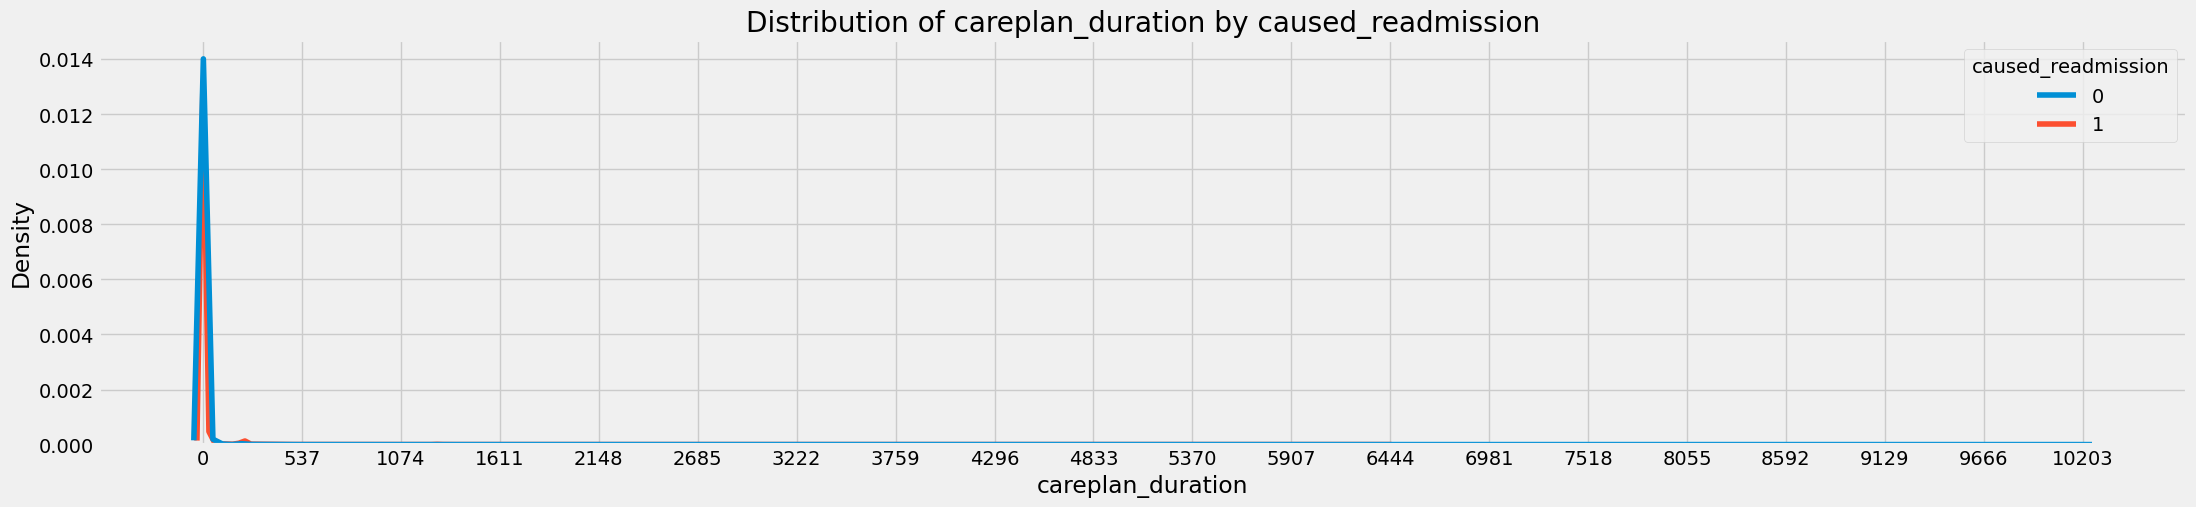

In [135]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='careplan_duration',data= data,target='caused_readmission')

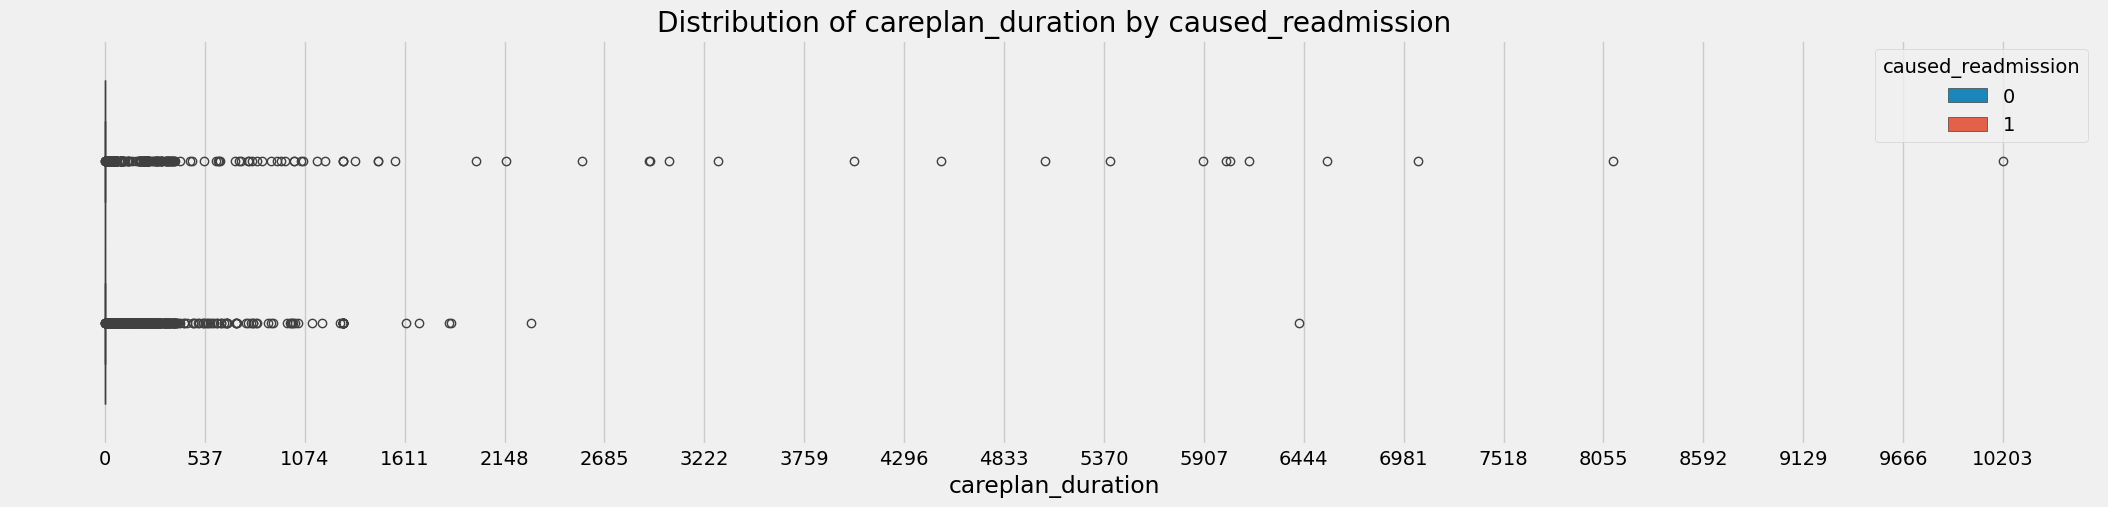

In [136]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='careplan_duration',data= data,target='caused_readmission')

In [137]:
data.groupby('caused_readmission')['careplan_duration'].mean().round(2)

caused_readmission
0     5.5
1    9.49
Name: careplan_duration, dtype: Float64

In [138]:
S.numerical_test(data,'caused_readmission','careplan_duration',1)

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00002 → Reject null (groups different)
Strength of ttest: very weak


- **nothing too specific, but groups are different**